In [1]:
pip install unidecode

     |████████████████████████████████| 235 kB 15.2 MB/s 


# Introdução

Nesse desafio, nosso principal objetivo é o de clusterizar a base de clientes do Ifood e encontrar padrões e levantar insights a partir dos dados analisados

Há quatro base de dados para esse desafio:


# Configuração

In [314]:
# importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from numpy import asarray

from datetime import datetime as dt
from datetime import timedelta as td

# Feature importance
from sklearn.preprocessing import RobustScaler

from unidecode import unidecode

import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Funções de suporte

In [4]:
# Definindo a faixa interquartil e verificando quantidade de outliers
def outliers(df, feature):

    FIQ = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    outliers_sup = df[feature].quantile(0.75) + FIQ
    outliers_inf = df[feature].quantile(0.25) - FIQ
    return print('outliers superior:', round((df[feature] > outliers_sup).sum()/len(df[feature])*100,2),'%'),
    print('outliers inferior:', round((df[feature] < outliers_inf).sum()/len(df[feature])*100,2),'%')

In [5]:
# criando histograma e boxplot
def hist_box(df, feature, ytickl='', title = ''):
  print(f'Mediana de {feature}:', df[feature].median())

  fig = plt.figure(figsize=(12, 6)) 
  gs = gridspec.GridSpec(2, 1, height_ratios=[1, 6]) 

  ax0 = plt.subplot(gs[0])
  ax0.boxplot(df[feature],
              vert=False,
              sym = '+',
              )
  ax0.set_yticklabels([ytickl])
  ax0.set_title(title)

  ax1 = plt.subplot(gs[1])
  ax1 = df[feature].hist(bins=50,
                        edgecolor='black',
                        linewidth=0.7,
                        grid=False)

  return fig.show()

In [6]:
# Função para verificar porcentagem de outliers
def outliers(df, feature):

    FIQ = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    outliers_sup = df[feature].quantile(0.75) + FIQ
    outliers_inf = df[feature].quantile(0.25) - FIQ
    return print('outliers superiores:',
                 round((df[feature] > outliers_sup).sum()/len(df[feature])*100,2),'%'),print('outliers inferiores:',
                       round((df[feature] < outliers_inf).sum()/len(df[feature])*100,2),'%')

# Importando Dados

In [7]:
# importando dados do Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [8]:
# importando os dados dos quatro arquivos
df_doc = pd.read_excel('/content/gdrive/My Drive/Curso TERA/Desafio Clustering/Dados/Documentação Base - Clustering.xlsx')
df_marketing = pd.read_csv('/content/gdrive/My Drive/Curso TERA/Desafio Clustering/Dados/marketing.csv', sep=';')
df_orders = pd.read_csv('/content/gdrive/My Drive/Curso TERA/Desafio Clustering/Dados/orders.csv', sep=';')
df_sessions = pd.read_csv('/content/gdrive/My Drive/Curso TERA/Desafio Clustering/Dados/sessions.csv', sep=';')

In [9]:
# descrições das features dos datasets
df_doc

,Nome da base,Nome da variável,Descrição
0,orders,order_id,ID único para pedido
1,orders,order_shift,0 - 4:59h - weekday/weekend dawn\n5 - 9:59h - ...
2,orders,order_origin,"Tipo do Merchant: STORE (loja), QUICKLY_MEAL (..."
3,orders,delivery_fee,Taxa de entrega paga pelo cliente
4,orders,scheduled,Booleano que indica se o pedido foi agendado
5,orders,total_amount,Valor total pago pelo cliente (em Unidades Mon...
6,orders,subsidy_amount,"Subsídio, desconto dado no pedido (em Unidades..."
7,orders,device_platform,Plataforma (sistema operacional) utilizado par...
8,orders,device_type,"Canal de origem do pedido (SITE, MOBILE, etc)"
9,orders,device_app_version,Versão do aplicativo do iFood que fez o pedido


In [10]:
# visual. dataset marketing
df_marketing

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12
...,...,...,...,...,...,...
20244,43ca9ecf-4a84-46c0-bddc-08500cc2dadd,2015-08-03,Inactive,Inactive,1186,2015-08-17
20245,bba67e7e-6760-4f0d-846c-b85af925acf1,2019-03-17,Inactive,Inactive,4,2019-12-11
20246,d0ceeec4-3cc6-4878-acf9-a0f4aeb95f66,2020-01-07,Inactive,Inactive,2,2020-02-13
20247,e0ec291a-cd2f-428a-a6ab-5f88b5d141dd,2017-08-12,Inactive,Inactive,263,2017-08-12


In [11]:
# visual. dataset orders
df_orders

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.00,False,5375.00,0.00,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.00,False,2987.50,1250.00,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.00,False,3737.50,2123.75,IOS,MOBILE,9.56.0,-23.6-46.64,SP,SAO PAULO,Vila Clementino,-46.65,-23.60,e648c3eeabfbbc52d415e4f2b4bb07ed0206c7fff7fb9c...,Comida Peruana,5384e3b557315ce815e7e3425a4d067f1ecff96978501e...,-23.61-46.67,SP,SAO PAULO,INDIANOPOLIS,4029200,-46.67,-23.62,True,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3.0,a16865d2-a3ca-4251-afab-083dadeb06e9,5.0,5,2020-07-03T03:49:03.214Z
3,007199e6-6be4-42d0-986c-a0de7650dc80,weekday dinner,RESTAURANT,862.50,False,2237.50,1.25,DESKTOP,SITE,8.39.0,-22.96-43.39,RJ,RIO DE JANEIRO,Curicica,-43.39,-22.96,c3b2f2bc35b781c126ab4e78db73aa5609e55b1eff34c8...,Pizza,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.96-43.4,RJ,RIO DE JANEIRO,Curicica,22780193,-43.40,-22.96,False,2020-08-19T20:16:16.718Z,2020-08-19T22:16:16.298Z,0.0,a7f00fd8-d5d6-4604-9bce-ffe35b16848d,5.0,10,2020-08-26T17:44:08.137Z
4,00bb6d10-0a9b-4fe3-9b25-8d18f50bcc3a,weekday lunch,RESTAURANT,0.00,False,2750.00,0.00,DESKTOP,SITE,8.12.0,-23.57-46.64,SP,SAO PAULO,Liberdade,-46.64,-23.57,63271292b131c157593c309acfcbcd5756ec1440879e64...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.59-46.64,SP,SAO PAULO,Vila Mariana,4009002,-46.64,-23.59,True,2020-04-15T13:01:55.231Z,2020-04-15T17:02:37.723Z,1.0,63284037-3ade-4600-88e9-5009b9504d8f,5.0,10,2020-04-17T22:05:13.983Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226264,fe810a8e-97be-4a85-a6c0-eb446fd72fd9,weekend dawn,RESTAURANT,375.00,False,10437.50,0.00,IOS,MOBILE,9.52.0,-22.95-43.34,RJ,RIO DE JANEIRO,ANIL,-43.34,-22.95,d07d54994d14abe915f1fd678ed66284d6810d60344536...,Lanches,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.95-43.36,RJ,RIO DE JANEIRO,Cidade de Deus,22763011,-43.36,-22.95,False,2020-05-31T01:12:22.097Z,2020-05-31T03:23:49.538Z,2.0,f415e4e7-097a-4b32-8fb9-6361658db37b,5.0,10,2020-05-31T06:24:22.437Z
226265,feb7b532-9602-4623-b89d-32697a0b6e17,weekday breakfast,RESTAURANT,873.75,False,6348.75,0.00,ANDROID,MOBILE,9.56.0,-23.6-46.61,SP,SAO PAULO,Vila Nair,-46.61,-23.61,70f36e5a2493ada1c021b99241012501a241d946c2564a...,Padaria,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.58-46.61,SP,SAO PAULO,Ipiranga,4205001,-46.61,-23.59,False,2020-06-30T08:27:56.247Z,2020-06-30T08:51:08.729Z,1.0,d03e5849-703e-4e49-a051-7a5d652c3b28,5.0,10,2020-06-30T17:13:24.936Z
226266,ff54b0d0-6bd3-4bad-a34c-ec64f0b17787,weekday dinner,RESTAURANT,875.00,False,8512.50,1.25,IOS,MOBILE,9.48.0,-23.58-4

In [12]:
# visual. dataset sessions
df_sessions

,session_id,user_account_uuid,session_started,session_ended,install_timestamp,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,first_order_has_voucher,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z,NaN,19,5,6,6,7,False,NaN,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z,NaN,14,1,0,0,0,NaN,NaN,5.0,128.0,2
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01T00:00:14.479Z,2020-02-01T00:08:20.102Z,NaN,31,4,4,3,1,False,NaN,6.0,187.0,3
3,39ca6d98-c9d1-4dff-9158-c7416be6d309,d7ddb2ac-31bf-4e3d-848a-9efc86a70f6d,2020-02-01T00:00:14.650Z,2020-02-01T00:02:49.615Z,NaN,12,3,0,0,0,NaN,NaN,5.0,22.0,4
4,cf456658-0426-46c2-b6c1-fc27c186e15e,8d9bb514-cc57-4181-bb9d-b94b7fbbfd98,2020-02-01T00:00:41.607Z,2020-02-01T00:16:57.415Z,NaN,4,0,0,0,0,NaN,NaN,28.0,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591506,85770037-9a5c-4ac3-8ba3-ae2b83135e73,9b8c5cb4-837d-4457-bf66-ac1ecdf108cd,2020-09-30T23:59:29.388Z,2020-10-01T00:00:18.295Z,NaN,6,1,1,1,0,NaN,NaN,4.0,220.0,3591507
3591507,45072446-a0cd-4747-8de9-07875633c5e0,9eb99387-ee18-4930-801b-b7201ae46df9,2020-09-30T23:59:37.159Z,2020-10-01T00:44:50.978Z,NaN,3,1,1,2,2,NaN,NaN,3.0,460.0,3591508
3591508,871c9936-e287-439b-88e5-f85e9fdde177,23aeed54-ec20-448f-8857-d321c18cf411,2020-09-30T23:59:40.218Z,2020-10-01T00:01:49.361Z,NaN,0,0,0,0,0,NaN,NaN,4.0,241.0,3591509
3591509,bda71adc-50bb-48bd-82cc-647174b3bfa5,4b8bc8a5-cf2d-4d77-bea9-64ed735fe4ec,2020-09-30T23:59:51.837Z,2020-10-01T00:01:56.597Z,NaN,2,0,0,0,0,NaN,NaN,3.0,14.0,3591510


In [13]:
# informações gerais do df de marketing
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_id               20249 non-null  object
 1   registration_date        20249 non-null  object
 2   ifood_status             20249 non-null  object
 3   ifood_status_last_month  20249 non-null  object
 4   total_order_count        20249 non-null  int64 
 5   first_order_date         20248 non-null  object
dtypes: int64(1), object(5)
memory usage: 949.3+ KB


In [14]:
# informações gerais do df de ordens
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  bool   
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  centroid_id           226269 non-null  object 
 11  state_label           226269 non-null  object 
 12  city                  226269 non-null  object 
 13  district              226269 non-null  object 
 14  customer_long         226269 non-null  float64
 15  

In [15]:
# informações gerais do df de sessions
df_sessions.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   session_id                  3591511 non-null  object 
 1   user_account_uuid           3591511 non-null  object 
 2   session_started             3591511 non-null  object 
 3   session_ended               3545766 non-null  object 
 4   install_timestamp           11543 non-null    object 
 5   sum_view_restaurant_screen  3591511 non-null  int64  
 6   sum_view_dish_screen        3591511 non-null  int64  
 7   sum_click_add_item          3591511 non-null  int64  
 8   sum_view_checkout           3591511 non-null  int64  
 9   sum_callback_purchase       3591511 non-null  int64  
 10  first_order_has_voucher     420630 non-null   object 
 11  media_campaign              53423 non-null    object 
 12  load_time                   2848111 non-null  float64
 1

## Conclusão da importação dos dados

Temos três datasets: marketing, orders e sessions


*   Sessions corresponde a todas as sessões abertas, mesmo que não tenham convertido em compras. No total, foram 3591511 sessões para o período analisado. As features session_ended, install_timestamp, first_order_has_voucher e media_campaign possuem dados vazios.
*   Orders corresponde às compras realizadas. Foram 226269 ordens, com 34 features. As features device_app_version, confirmed_date, concluded_date e lag_last_order possuem dados nulos

*   Marketing é o df de dados do usuário. São 20249 dados, cada um sendo um cliente diferente. Somente a feature first_order_date possui dados vazios

# EDA

Nessa etapa, vamos:

*   analisar os dados das três bases, separadamente (a princípio)
*   decidir o que faremos com os dados faltantes
*   verificar os outliers
*   Tirar insights da exploração dos dados
*   Criar features

Obs: Somente valores que não fazem sentido serão eliminados nessa etapa. Os outliers não serão tratados, nem excluídos. Para que eles não "atrapalhem" nosso modelo de clustering, vamos utilizar uma técnica de padronização menos sensível a eles

Os datasets finais serão:


1.   df_marketing_model
2.   df_orders_model
3.   df_sessions_model





In [16]:
# criando os dataframes modelos
df_marketing_model = pd.DataFrame()
df_orders_model = pd.DataFrame()
df_sessions_model = pd.DataFrame()

## Marketing Dataset

In [17]:
# criando uma cópia do dataset
df_marketing_copia = df_marketing.copy()

In [18]:
# informações gerais do dataset
df_marketing_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_id               20249 non-null  object
 1   registration_date        20249 non-null  object
 2   ifood_status             20249 non-null  object
 3   ifood_status_last_month  20249 non-null  object
 4   total_order_count        20249 non-null  int64 
 5   first_order_date         20248 non-null  object
dtypes: int64(1), object(5)
memory usage: 949.3+ KB


In [19]:
# transformando as features registration_date e first_order_date em datetime
df_marketing_copia['first_order_date'] = pd.to_datetime(df_marketing_copia['first_order_date'], format='%Y-%m-%d')
df_marketing_copia['registration_date'] = pd.to_datetime(df_marketing_copia['registration_date'], format='%Y-%m-%d')

In [20]:
# informações gerais do dataset
df_marketing_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               20249 non-null  object        
 1   registration_date        20249 non-null  datetime64[ns]
 2   ifood_status             20249 non-null  object        
 3   ifood_status_last_month  20249 non-null  object        
 4   total_order_count        20249 non-null  int64         
 5   first_order_date         20248 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 949.3+ KB


In [21]:
df_marketing_copia.head()

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12


In [22]:
# verificando account_id repetidos
df_marketing_copia['account_id'].duplicated(keep=False).sum()

0

In [23]:
df_marketing_model['account_id'] = df_marketing_copia['account_id']



*   **Dates registration and first order**: Verificando a quantidade por ano


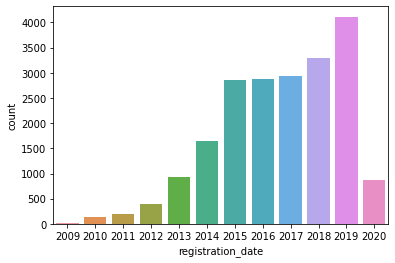

In [24]:
sns.countplot(df_marketing_copia.registration_date.dt.year)

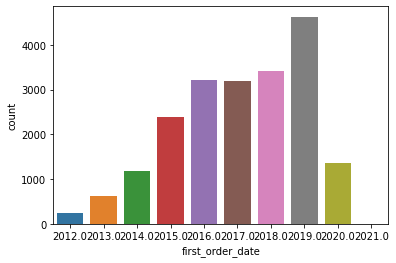

In [25]:
sns.countplot(df_marketing_copia.first_order_date.dt.year)

In [26]:
df_marketing_copia.first_order_date.mode()

0   2020-02-14
dtype: datetime64[ns]

In [27]:
# preenchendo os dados faltantes com a moda
df_marketing_copia.first_order_date.fillna('2020-02-14',
                                           inplace = True)

In [28]:
# informações gerais do dataset
df_marketing_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               20249 non-null  object        
 1   registration_date        20249 non-null  datetime64[ns]
 2   ifood_status             20249 non-null  object        
 3   ifood_status_last_month  20249 non-null  object        
 4   total_order_count        20249 non-null  int64         
 5   first_order_date         20249 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 949.3+ KB


In [29]:
df_marketing_model['registration_date'] = df_marketing_copia['registration_date']
df_marketing_model['first_order_date'] = df_marketing_copia['first_order_date']



*   **Status do Cliente**: Distribuição por status



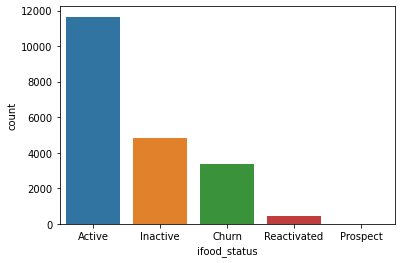

In [30]:
# Verificando a distribuição do status do cliente
sns.countplot(df_marketing_copia.ifood_status,
              order = df_marketing_copia.ifood_status.value_counts().index)

In [31]:
df_marketing_model['ifood_status'] = df_marketing_copia['ifood_status']



*   **Total order count**



In [32]:
df_marketing_copia.total_order_count.describe()

count    20249.000000
mean       341.321201
std        303.150112
min          0.000000
25%         91.000000
50%        286.000000
75%        501.000000
max       3098.000000
Name: total_order_count, dtype: float64

Mediana de total_order_count: 286.0


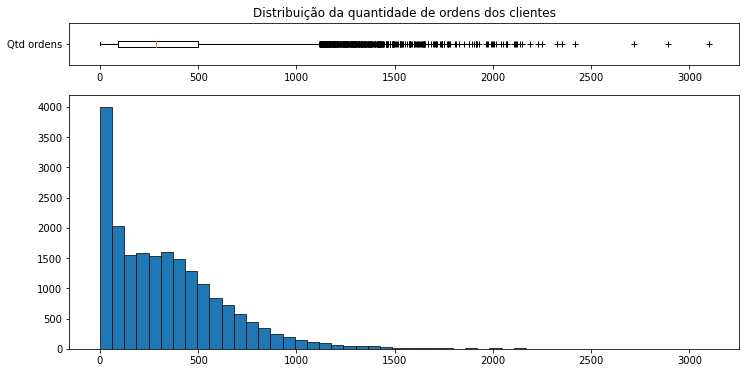

In [33]:
# verificando distribuição das quantidades de ordens
hist_box(df_marketing_copia, 'total_order_count', ytickl='Qtd ordens', title = 'Distribuição da quantidade de ordens dos clientes')

In [34]:
# verificando outliers %
outliers(df_marketing_copia, 'total_order_count')

outliers superiores: 4.81 %
outliers inferiores: 0.0 %


(None, None)

In [35]:
df_marketing_model['total_order_count'] = df_marketing_copia['total_order_count']

In [36]:
df_marketing_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   account_id         20249 non-null  object        
 1   registration_date  20249 non-null  datetime64[ns]
 2   first_order_date   20249 non-null  datetime64[ns]
 3   ifood_status       20249 non-null  object        
 4   total_order_count  20249 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 791.1+ KB


### Conclusão Marketing



*   Não há account_id repetido
*   datas de registro e de primeira ordem foram transformadas para formatos de data
*   Há mais usuários ativos do que outros status. No entanto, há consideráveis inativos e churns. Podemos avaliar esses casos mais profundamente em estudos específicos
*   Mediana de total gasto é de 286, com curva assimétrica à direita



## Orders

In [37]:
# criando um df de cópia de orders
df_orders_copia = df_orders.copy()

In [38]:
df_orders_copia.describe()

,delivery_fee,total_amount,subsidy_amount,customer_long,customer_lat,merchant_zipcode,merchant_long,merchant_lat,lag_last_order,review_score,nps_score
count,226269.000000,226269.000000,226269.000000,226269.000000,226269.000000,2.262690e+05,226269.000000,226269.000000,226085.000000,226269.000000,226269.000000
mean,405.418965,6017.809350,343.687580,-45.693016,-23.192878,1.693620e+07,-45.692937,-23.193716,2.505275,4.666207,9.108150
std,504.026635,5180.780032,677.852181,2.184032,2.206372,2.094803e+07,2.194552,2.206171,11.985040,0.928577,1.895903
min,-1247.500000,0.000000,-2.500000,-67.870000,-31.780000,0.000000e+00,-67.840000,-31.780000,0.000000,1.000000,1.000000
25%,0.000000,2768.750000,0.000000,-46.710000,-23.600000,4.048000e+06,-46.700000,-23.600000,0.000000,5.000000,9.000000
50%,0.000000,4500.000000,0.000000,-46.620000,-23.530000,6.473073e+06,-46.620000,-23.540000,1.000000,5.000000,10.000000
75%,748.750000,7523.750000,623.750000,-43.350000,-22.940000,2.222003e+07,-43.350000,-22.950000,2.000000,5.000000,10.000000
max,5000.000000,174873.750000,19611.250000,-34.820000,2.850000,9.907006e+07,46.790000,2.850000,1429.000000,5.000000,10.000000


In [39]:
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  bool   
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  centroid_id           226269 non-null  object 
 11  state_label           226269 non-null  object 
 12  city                  226269 non-null  object 
 13  district              226269 non-null  object 
 14  customer_long         226269 non-null  float64
 15  

In [40]:
# verificando features com dados faltantes
df_orders_copia.isnull().sum()

order_id                   0
order_shift                0
order_origin               0
delivery_fee               0
scheduled                  0
total_amount               0
subsidy_amount             0
device_platform            0
device_type                0
device_app_version      4435
centroid_id                0
state_label                0
city                       0
district                   0
customer_long              0
customer_lat               0
restaurant_id              0
dish_type                  0
group_id                   0
merchant_centroid_id       0
merchant_state             0
merchant_city              0
merchant_district          0
merchant_zipcode           0
merchant_long              0
merchant_lat               0
has_free_delivery          0
confirmed_date            14
concluded_date             4
lag_last_order           184
account_id                 0
review_score               0
nps_score                  0
review_created_at          0
dtype: int64



*   **account_id**



In [41]:
# incluindo na versao de modelo de ordens
df_orders_model['account_id'] = df_orders_copia['account_id']



*   **order_shift**



In [42]:
df_orders_copia.order_shift.value_counts()

weekday lunch        58433
weekday dinner       53720
weekend dinner       50821
weekend lunch        22782
weekday snack        13382
weekday breakfast    12358
weekend snack         5909
weekday dawn          3828
weekend dawn          3329
weekend breakfast     1707
Name: order_shift, dtype: int64

In [43]:
# incluindo na versao de modelo de ordens
df_orders_model['order_shift'] = df_orders_copia['order_shift']



*   **order_origin**



In [44]:
df_orders_copia.order_origin.value_counts()

RESTAURANT      219886
STORE             4798
QUICKLY_MEAL      1585
Name: order_origin, dtype: int64

In [45]:
# incluindo na versao de modelo de ordens
df_orders_model['order_origin'] = df_orders_copia['order_origin']



*   **delivery_fee**



Mediana de delivery_fee: 0.0


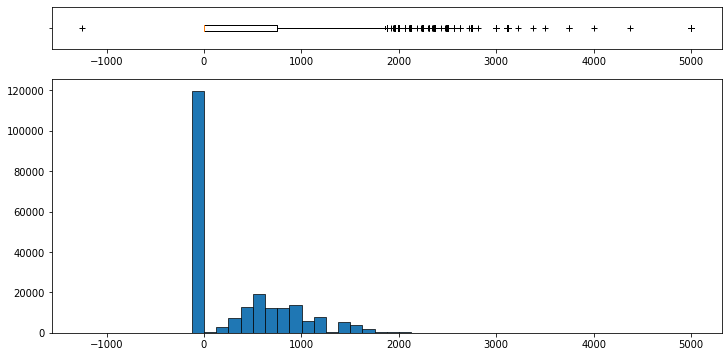

In [46]:
hist_box(df_orders_copia,'delivery_fee')

In [47]:
# verificando outliers
outliers(df_orders_copia,'delivery_fee')

outliers superiores: 4.89 %
outliers inferiores: 0.0 %


(None, None)

Como há um poucos valores negativos, vamos seta-los para 0.

In [48]:
# quantidade de valores negativos
(df_orders_copia['delivery_fee']<0).sum()

1

In [49]:
# substituindo valores menores que 0 por 0
df_orders_copia.loc[df_orders_copia['delivery_fee']<0] = 0

Mediana de delivery_fee: 0.0


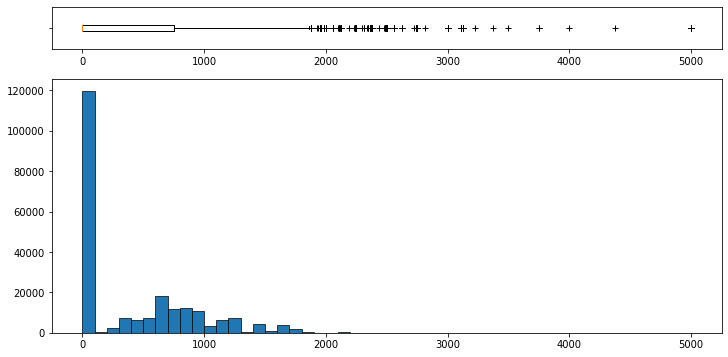

In [50]:
hist_box(df_orders_copia,'delivery_fee')

In [51]:
# incluindo na versao de modelo de ordens
df_orders_model['delivery_fee'] = df_orders_copia['delivery_fee']



*   **scheduled**: bool que indica se o pedido foi agendado



In [52]:
df_orders_copia.scheduled.value_counts()

False    220683
True       5586
Name: scheduled, dtype: int64

In [53]:
# incluindo na versao de modelo de ordens
df_orders_model['scheduled'] = df_orders_copia['scheduled']



*   **total_amount**: valores totais de cada ordem



Mediana de total_amount: 4500.0


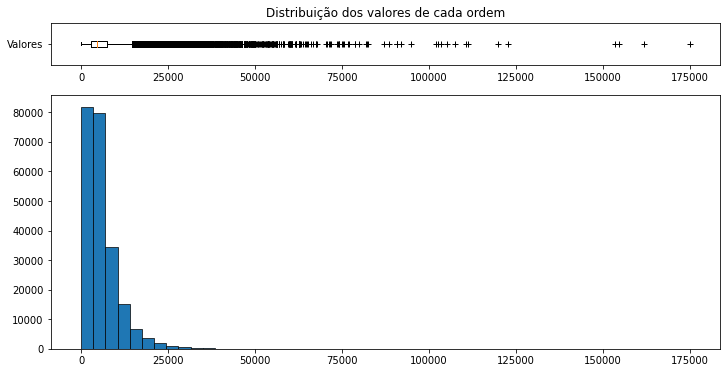

In [54]:
hist_box(df_orders_copia, 'total_amount', 'Valores', 'Distribuição dos valores de cada ordem')

In [55]:
# verificando outliers
outliers(df_orders_copia,'total_amount')

outliers superiores: 9.21 %
outliers inferiores: 0.0 %


(None, None)

In [56]:
# incluindo na versao de modelo de ordens
df_orders_model['total_amount'] = df_orders_copia['total_amount']



*   **subsidy_amount**: descontos nos pedidos



Mediana de subsidy_amount: 0.0


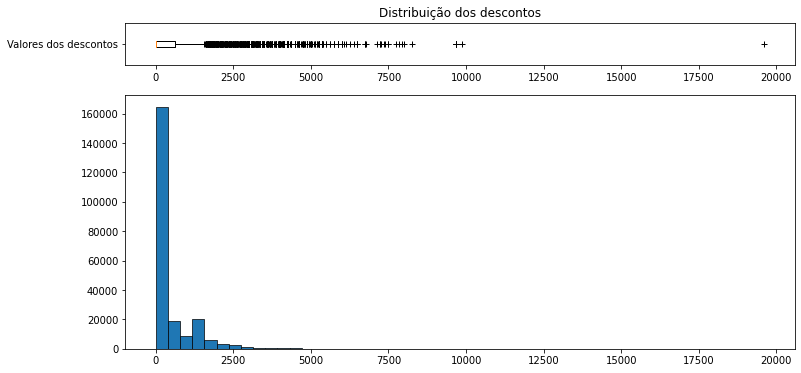

In [57]:
hist_box(df_orders_copia, 'subsidy_amount', 'Valores dos descontos', 'Distribuição dos descontos')

In [58]:
# verificando outliers
outliers(df_orders_copia,'subsidy_amount')

outliers superiores: 14.84 %
outliers inferiores: 0.0 %


(None, None)

In [59]:
# incluindo na versao de modelo de ordens
df_orders_model['subsidy_amount'] = df_orders_copia['subsidy_amount']



*   **device_platform**



In [60]:
df_orders_copia.device_platform.value_counts()

ANDROID    118145
IOS         85039
DESKTOP     23084
0               1
Name: device_platform, dtype: int64

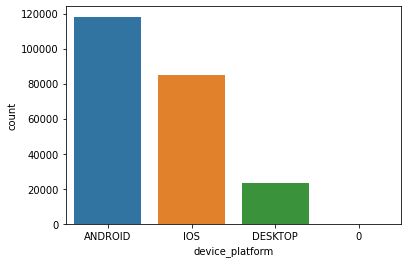

In [61]:
sns.countplot(df_orders_copia.device_platform)

In [62]:
# incluindo na versao de modelo de ordens
df_orders_model['device_platform'] = df_orders_copia['device_platform']



*   **device_type**



In [63]:
df_orders_copia.device_type.value_counts()

MOBILE    202493
SITE       23775
0              1
Name: device_type, dtype: int64

In [64]:
# substituindo valor 0 pela moda
df_orders_copia.device_type.replace(0, 'MOBILE', inplace = True)

In [65]:
df_orders_copia.device_type.value_counts()

MOBILE    202494
SITE       23775
Name: device_type, dtype: int64

In [66]:
# incluindo na versao de modelo de ordens
df_orders_model['device_platform'] = df_orders_copia['device_platform']



*   **device_app_version**



In [67]:
df_orders_copia.device_app_version.nunique()

214

Há 214 verões de app diferentes. Dessa forma, não vou plotar gráficos de frequência para eles. Além disso, tantas classes podem atrapalhar o modelo. Podemos considerar remover essa feature.

Dessa forma, ela não será incluida em df_orders_model



*   **centroid_id**: id da centroide do cliente



In [68]:
df_orders_copia.centroid_id.nunique()

4142

In [69]:
df_orders_copia.centroid_id[:20]

0     -22.83-43.35
1     -22.93-43.18
2      -23.6-46.64
3     -22.96-43.39
4     -23.57-46.64
5     -23.01-43.37
6     -25.43-49.22
7     -22.92-43.38
8     -23.59-46.79
9      -23.5-46.68
10    -23.55-46.64
11    -22.97-43.19
12    -22.93-43.35
13    -22.88-43.59
14     -23.5-46.68
15    -22.93-43.19
16    -22.94-43.18
17     -23.49-46.5
18     -23.5-46.58
19    -25.44-49.31
Name: centroid_id, dtype: object

O dado de centroide está em coordenadas, porém na mesma coluna. Vamos separar lat de long

In [70]:
# separando por -
df_centroide_id=df_orders_copia.centroid_id.str.split(r"-", expand=True)

In [71]:
# criando features de lat e long de centroide id na df_orders_copia
df_orders_copia['centroide_id_lat'] = df_centroide_id[1].astype(float)*(-1)
df_orders_copia['centroide_id_long'] = df_centroide_id[2].astype(float)*(-1)

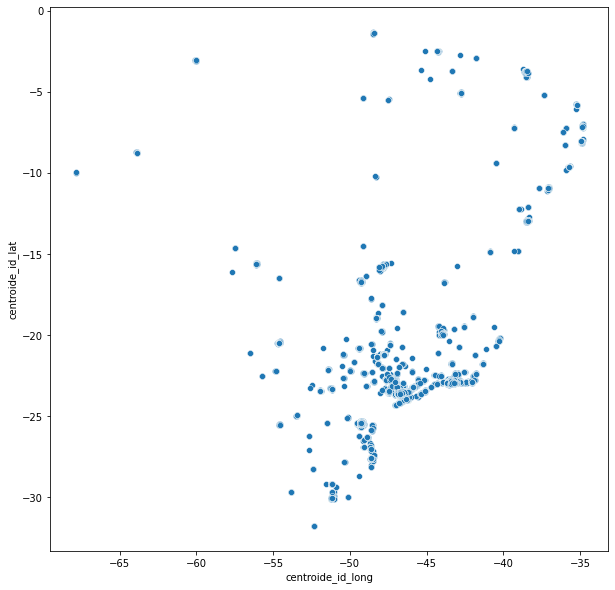

In [72]:
plt.figure(figsize = (10,10))
sns.scatterplot(y = df_orders_copia['centroide_id_lat'],
                x = df_orders_copia['centroide_id_long'])

Podemos ver, apesar de ser apenas um scatterplot, que na região Sudeste há uma concentração maior de ordens realizadas.

Como essa análise era apenas para dar uma visão geral, não vamos entrar em técnicas melhore de visualização de mapas.

Como separamos os dados de lat e long em novas colunas, podemos droppar a centroide_id

In [73]:
df_orders_copia.drop('centroid_id', axis=1, inplace=True)
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  object 
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  state_label           226269 non-null  object 
 11  city                  226269 non-null  object 
 12  district              226269 non-null  object 
 13  customer_long         226269 non-null  float64
 14  customer_lat          226269 non-null  float64
 15  

Como essa feature é igual a outras utilizadas mais para frente, ela não será incluida em df_orders_model



*   **state_label**



In [74]:
df_orders_copia.state_label.value_counts()

SP    129941
RJ     74738
PR     14216
MG      1432
DF       821
RS       814
CE       796
SC       489
PA       334
GO       305
ES       300
BA       269
PE       240
MS       222
AM       195
SE       185
PB       174
MT       163
PI       160
AL       136
RN       118
RR        81
MA        69
RO        59
AP         6
TO         3
AC         2
0          1
Name: state_label, dtype: int64

In [75]:
# incluindo na versao de modelo de ordens
df_orders_model['state_label'] = df_orders_copia['state_label']



*   **city**



In [76]:
# numero de cidades únicas do dataset
df_orders_copia.city.nunique()

316

In [77]:
df_orders_copia.city.value_counts()[:10]

SAO PAULO         115185
RIO DE JANEIRO     70862
CURITIBA           13206
NITEROI             1761
GUARULHOS           1705
OSASCO              1332
CAMPINAS            1042
SANTO ANDRE          983
BRASILIA             821
FORTALEZA            615
Name: city, dtype: int64

As cidades que mais recebem pedidos pelo app são majoritariamente dos estados de São Paulo e Rio de Janeiro

In [78]:
# incluindo na versao de modelo de ordens
df_orders_model['city'] = df_orders_copia['city']



*   **district**



In [79]:
# contando os valores unicos de distritos
df_orders_copia.district.nunique()

4444

In [80]:
# observando as maiores ocorrencias
df_orders_copia.district.value_counts()[:10]

Vila Mariana          4023
Centro                3588
Bela Vista            3371
COPACABANA            3013
Copacabana            2992
TIJUCA                2973
BARRA DA TIJUCA       2885
Barra da Tijuca       2671
BOTAFOGO              2144
Jardim Monte Kemel    1927
Name: district, dtype: int64

Vemos que os nomes dos distritos não estão padronizados. Assim vamos padroniza-los.

Primeiro, vamos transformar todas as letras em maiúsculas e depois retirar todos os caracteres especiais.

In [81]:
# retirando caracteres especiais e transform. em maiúsculas
df_orders_copia.district = [unidecode(x) for x in (df_orders_copia.district).astype(str).str.upper()]

In [82]:
df_orders_copia.district.nunique()

3304

In [83]:
# observando as maiores ocorrencias, após padronização dos nomes
df_orders_copia.district.value_counts()[:10]

COPACABANA         6012
BARRA DA TIJUCA    5556
BELA VISTA         5111
VILA MARIANA       5110
CENTRO             4908
TIJUCA             4663
BOTAFOGO           3365
VILA SONIA         2649
JACAREPAGUA        2379
ITAIM BIBI         2329
Name: district, dtype: int64

In [84]:
# incluindo na versao de modelo de ordens
df_orders_model['district'] = df_orders_copia['district']



*   **customer_long e customer_lat**: avaliando os dois ao mesmo tempo



In [85]:
df_orders_copia.customer_long

0        -43.35
1        -43.18
2        -46.65
3        -43.39
4        -46.64
          ...  
226264   -43.34
226265   -46.61
226266   -46.72
226267   -43.20
226268   -46.74
Name: customer_long, Length: 226269, dtype: float64

In [86]:
df_orders_copia.customer_lat

0        -22.83
1        -22.94
2        -23.60
3        -22.96
4        -23.57
          ...  
226264   -22.95
226265   -23.61
226266   -23.59
226267   -22.96
226268   -23.63
Name: customer_lat, Length: 226269, dtype: float64

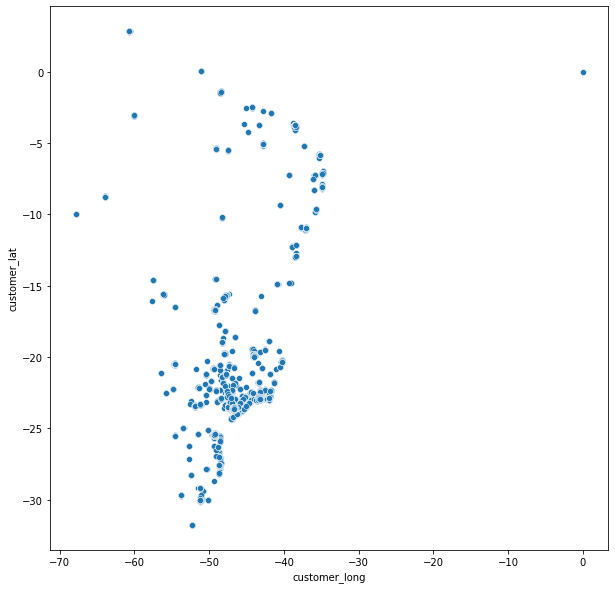

In [87]:
# plotando os dados de lat e long dos customers
plt.figure(figsize = (10,10))
sns.scatterplot(y = df_orders_copia['customer_lat'],
                x = df_orders_copia['customer_long'])

Vemos que há um dado de longitude que está claramente errado. Assim, vamos tentarcorrigi-lo da melhor forma. 

In [88]:
df_orders_copia.loc[df_orders_copia['customer_long'] == 0]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long
184958,0,0,0,0.0,0,0.0,0.0,0,MOBILE,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0,0,NaN,NaN


Como a linha toda está zerada, podemos elimina-la

In [89]:
df_orders_copia.drop(184958, inplace = True)
df_orders_model.drop(184958, inplace = True)

In [90]:
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226268 non-null  object 
 1   order_shift           226268 non-null  object 
 2   order_origin          226268 non-null  object 
 3   delivery_fee          226268 non-null  float64
 4   scheduled             226268 non-null  object 
 5   total_amount          226268 non-null  float64
 6   subsidy_amount        226268 non-null  float64
 7   device_platform       226268 non-null  object 
 8   device_type           226268 non-null  object 
 9   device_app_version    221833 non-null  object 
 10  state_label           226268 non-null  object 
 11  city                  226268 non-null  object 
 12  district              226268 non-null  object 
 13  customer_long         226268 non-null  float64
 14  customer_lat          226268 non-null  float64
 15  

Agora vamos plotar novamente

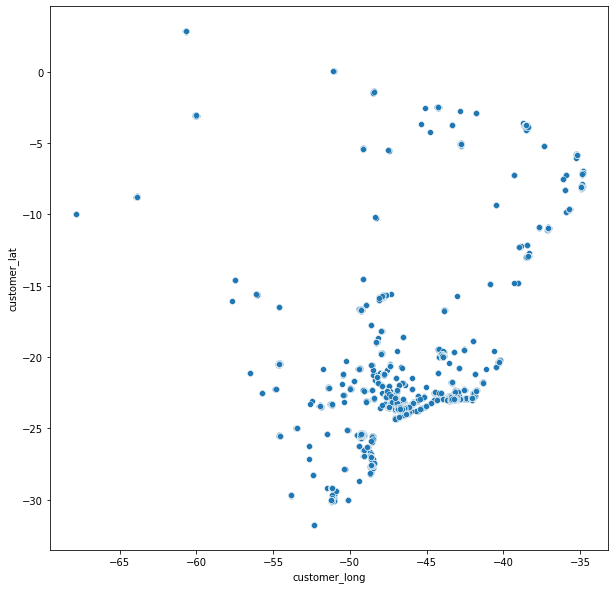

In [91]:
# plotando os dados de lat e long dos customers
plt.figure(figsize = (10,10))
sns.scatterplot(y = df_orders_copia['customer_lat'],
                x = df_orders_copia['customer_long'])

Descobrimos que a distribuição é a mesma que a de centroide.

No entanto, foi bom ter feito essa verificação, para eliminarmos uma linha vazia

Portanto, podemos não considerar as features customer lat e long no df modelo

In [92]:
# informações do df
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226268 non-null  object 
 1   order_shift           226268 non-null  object 
 2   order_origin          226268 non-null  object 
 3   delivery_fee          226268 non-null  float64
 4   scheduled             226268 non-null  object 
 5   total_amount          226268 non-null  float64
 6   subsidy_amount        226268 non-null  float64
 7   device_platform       226268 non-null  object 
 8   device_type           226268 non-null  object 
 9   device_app_version    221833 non-null  object 
 10  state_label           226268 non-null  object 
 11  city                  226268 non-null  object 
 12  district              226268 non-null  object 
 13  customer_long         226268 non-null  float64
 14  customer_lat          226268 non-null  float64
 15  

In [93]:
# incluindo na versao de modelo de ordens
df_orders_model['customer_long'] = df_orders_copia['customer_long']
df_orders_model['customer_lat'] = df_orders_copia['customer_lat']

In [94]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   account_id       226268 non-null  object 
 1   order_shift      226268 non-null  object 
 2   order_origin     226268 non-null  object 
 3   delivery_fee     226268 non-null  float64
 4   scheduled        226268 non-null  object 
 5   total_amount     226268 non-null  float64
 6   subsidy_amount   226268 non-null  float64
 7   device_platform  226268 non-null  object 
 8   state_label      226268 non-null  object 
 9   city             226268 non-null  object 
 10  district         226268 non-null  object 
 11  customer_long    226268 non-null  float64
 12  customer_lat     226268 non-null  float64
dtypes: float64(5), object(8)
memory usage: 24.2+ MB




*   **restaurant_id**



In [95]:
# quantidade de valores unicos
df_orders_copia.restaurant_id.nunique()

38007

No período analisado, 38007 restaurantes tiveram pelo menos uma ordem recebida.

Neste momento, o id do restaurante não será considerado, pois há muitos dados diferentes e não possui uma característica, e sim, a identificação.

Assim, essa feature não será considerada no df_orders_model



*   **dish_type**: tipo de cozinha do restaurante




In [96]:
# quantidade de ordens por tipo de restaurante (20 maiores)
df_orders_copia.dish_type.value_counts()[:20]

Lanches              44267
Comida Brasileira    42109
Pizza                32496
Comida Japonesa      31408
Doces & Bolos         9592
Comida Saudável       8375
Comida Italiana       6773
Padaria               5976
Mercado               5115
Carnes                4655
Açaí                  4568
Comida Árabe          3821
Marmita               2726
Bebidas               2708
Comida Chinesa        2645
Comida Variada        2526
Frutos do Mar         2172
Salgados              2023
Sorvetes              1849
Pastel                1383
Name: dish_type, dtype: int64

In [97]:
# quantidade de tipos de restaurantes
df_orders_copia.dish_type.nunique()

61

In [98]:
# quantidade de ordens por tipo de restaurante (10 menores)
df_orders_copia.dish_type.value_counts()[-10:]

Espanhola            17
Congelados Fit       13
Grega                11
Baiana                8
Comida Marroquina     5
Colombiana            2
Africana              2
Xis                   2
Paranaense            1
Típica do Norte       1
Name: dish_type, dtype: int64

In [99]:
# distribuição dos locais por tipo de comida
tipos_rest_20_maiores = df_orders_copia.dish_type.value_counts()[:20].index
df_orders_tipos_rest = df_orders_copia[df_orders_copia.dish_type.isin(tipos_rest_20_maiores)]

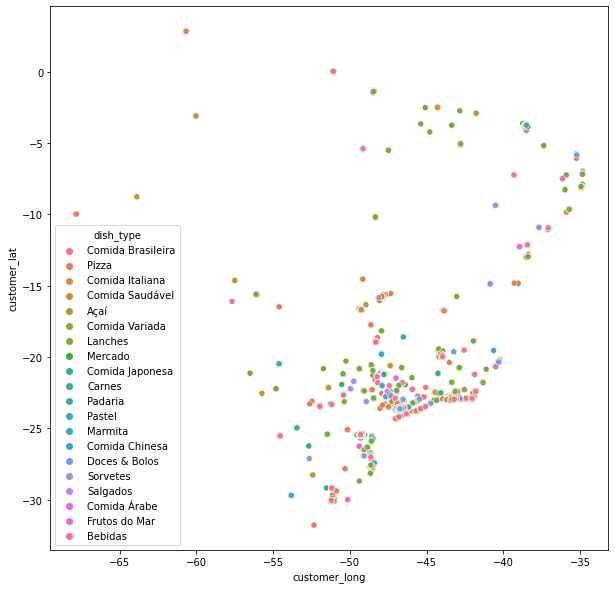

In [100]:
# plotando os dados de lat e long dos customers por tipo de comida
plt.figure(figsize = (10,10))
sns.scatterplot(x=df_orders_tipos_rest.customer_long,
                y=df_orders_tipos_rest.customer_lat,
                hue=df_orders_tipos_rest.dish_type)

O tipo de comida pode ser uma feature muito importante para a clusterização.


In [101]:
# incluindo na versao de modelo de ordens
df_orders_model['dish_type'] = df_orders_copia['dish_type']

In [102]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   account_id       226268 non-null  object 
 1   order_shift      226268 non-null  object 
 2   order_origin     226268 non-null  object 
 3   delivery_fee     226268 non-null  float64
 4   scheduled        226268 non-null  object 
 5   total_amount     226268 non-null  float64
 6   subsidy_amount   226268 non-null  float64
 7   device_platform  226268 non-null  object 
 8   state_label      226268 non-null  object 
 9   city             226268 non-null  object 
 10  district         226268 non-null  object 
 11  customer_long    226268 non-null  float64
 12  customer_lat     226268 non-null  float64
 13  dish_type        226268 non-null  object 
dtypes: float64(5), object(9)
memory usage: 25.9+ MB




*   **group_id**: grupo do restaurante, caso pertença a algum



In [103]:
# grupos unicos
df_orders_copia.group_id.nunique()

3497

In [104]:
# primeiros valores de group_id
df_orders_copia.group_id.head()

0    ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...
1    ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...
2    5384e3b557315ce815e7e3425a4d067f1ecff96978501e...
3    ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...
4    ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...
Name: group_id, dtype: object

Essa feature possui muitos valores únicos e não apresenta uma descrição clara. Dessa forma, não vamos considera-la na versão de modelo



*   **merchant_centroid_id**
*   **merchant_long**
*   **merchant_lat**




Vamos verificar se merchant centroid id corresponde às coordenadas das lojas. Se sim, podemos eliminar essa feature e ficar somente com long e lat

In [105]:
df_orders_copia[['merchant_centroid_id', 'merchant_lat', 'merchant_long']].head(20)

,merchant_centroid_id,merchant_lat,merchant_long
0,-22.82-43.38,-22.83,-43.38
1,-22.93-43.21,-22.93,-43.22
2,-23.61-46.67,-23.62,-46.67
3,-22.96-43.4,-22.96,-43.40
4,-23.59-46.64,-23.59,-46.64
5,-23.0-43.36,-23.00,-43.36
6,-25.4-49.25,-25.40,-49.25
7,-22.92-43.36,-22.93,-43.37
8,-23.59-46.76,-23.60,-46.76
9,-23.51-46.66,-23.52,-46.66


Como observado, os valores são os mesmos (ou com aproximação de 0.01) entre as features. Dessa forma, podemos não considerar a feature merchant_centroid_id e plotar as outras

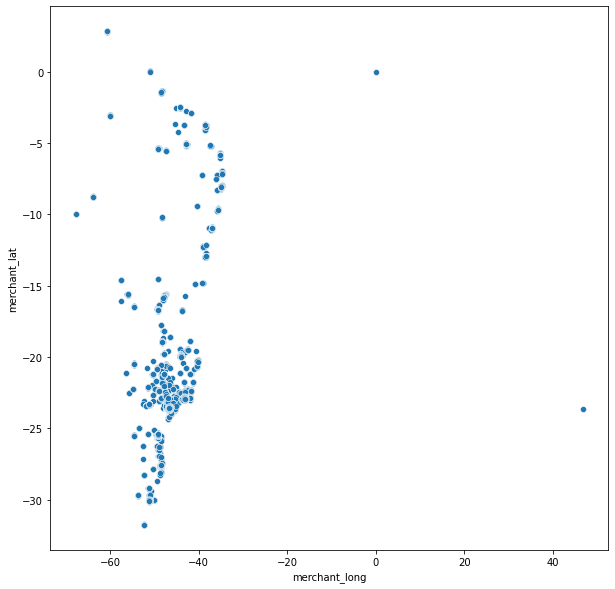

In [106]:
# plotando os dados de lat e long dos customers por tipo de comida
plt.figure(figsize = (10,10))
sns.scatterplot(x=df_orders_copia.merchant_long,
                y=df_orders_copia.merchant_lat)

Vamos identificar os valores que estão fora do escopo do país

In [107]:
# identificando linhas com valores de long maiores ou iguais a 0
df_orders_copia[df_orders_copia.merchant_long>=0]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long
175478,c90aa3b8-c937-4ebf-87ae-ef3bec8bb81c,weekend dinner,RESTAURANT,1250.0,False,8113.75,0.0,IOS,MOBILE,9.37.0,BA,SALVADOR,PIATA,-38.39,-12.94,17ae31fe1ddf9d125a5cf9d7915e1feda3251fff2170fb...,Pizza,d86bc87be34d20eaa64eff814dc33ca9530649c50de016...,0.00.0,BA,SALVADOR,Stella Mares,41600100,0.00,0.00,False,2020-02-23T20:23:22.681Z,2020-02-23T22:23:22.285Z,4.0,005416cc-7358-4696-9c42-0eea6f80d910,5.0,10,2020-02-25T00:49:39.955Z,-12.94,-38.39
222113,3c8f8171-3bda-410f-8799-1e905d5f28dc,weekday lunch,RESTAURANT,0.0,False,2500.00,1250.0,ANDROID,MOBILE,9.57.0,SP,SAO PAULO,JARDIM GUARUJA,-46.80,-23.70,7c2625409f6864c1bd518f28264c68463b859f356168ae...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.6446.79,SP,TABOAO DA SERRA,Pirajussara,6773290,46.79,-23.65,True,2020-07-02T11:50:44.233Z,2020-07-02T15:50:44.305Z,5.0,75f8df60-49a4-4874-8f42-27d1d76ac4ff,1.0,10,2020-07-15T17:25:16.635Z,-23.70,-46.80


Vamos preencher esses valores com as médias dados dos restaurantes da mesma cidade

In [108]:
df_orders_copia['merchant_long'].replace(0, df_orders_copia[df_orders_copia.merchant_city=='SALVADOR']['merchant_long'].mean(),
                                         inplace=True)
df_orders_copia['merchant_lat'].replace(0, df_orders_copia[df_orders_copia.merchant_city=='SALVADOR']['merchant_lat'].mean(),
                                         inplace=True)
df_orders_copia['merchant_long'].replace(46.79, df_orders_copia[df_orders_copia.merchant_city=='SAO PAULO']['merchant_long'].mean(),
                                         inplace=True)

In [109]:
# identificando linhas com valores de long maiores ou iguais a 0
df_orders_copia[df_orders_copia.merchant_long>=0]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long


In [110]:
df_orders_copia[df_orders_copia['merchant_lat']==0]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long


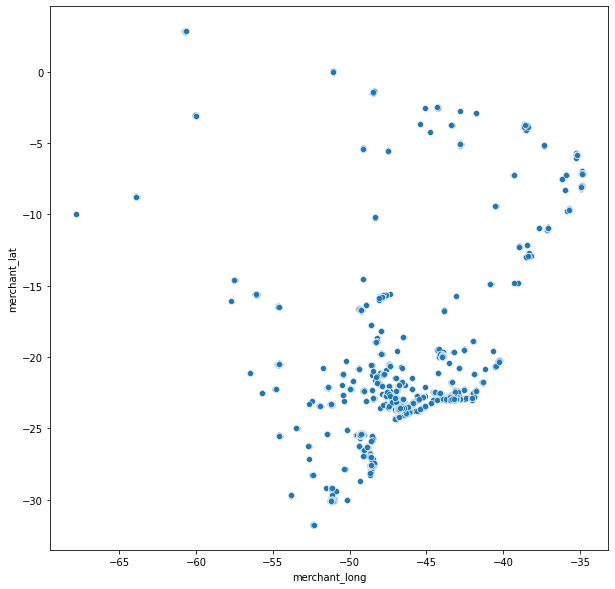

In [111]:
# plotando os dados de lat e long dos customers por tipo de comida
plt.figure(figsize = (10,10))
sns.scatterplot(x=df_orders_copia.merchant_long,
                y=df_orders_copia.merchant_lat)

Agora os dados parecem estar sem valores invalidos.

**Como temos dados de geolocalização tanto dos restaurantes como dos clientes, podemos criar feature de distância entre eles.**

In [112]:
# incluindo na versao de modelo de ordens
df_orders_model['merchant_long'] = df_orders_copia['merchant_long']
df_orders_model['merchant_lat'] = df_orders_copia['merchant_lat']



*   **merchant_state**



In [113]:
df_orders_copia.merchant_state.value_counts()

SP    129954
RJ     74742
PR     14216
MG      1434
DF       821
RS       811
CE       796
SC       485
PA       334
GO       304
ES       300
BA       269
PE       240
MS       222
AM       195
SE       186
MT       163
PB       162
PI       160
AL       136
RN       118
RR        81
MA        69
RO        59
AP         6
TO         3
AC         2
Name: merchant_state, dtype: int64

In [114]:
# incluindo na versao de modelo de ordens
df_orders_model['merchant_state'] = df_orders_copia['merchant_state']



*   **merchant_city**



In [115]:
df_orders_copia.merchant_city.value_counts()

SAO PAULO                   113612
RIO DE JANEIRO               70675
CURITIBA                     12932
GUARULHOS                     1821
OSASCO                        1804
NITEROI                       1740
SANTO ANDRE                   1233
CAMPINAS                      1111
BRASILIA                       818
SAO BERNARDO DO CAMPO          739
SAO CAETANO DO SUL             718
FORTALEZA                      617
BELO HORIZONTE                 568
PORTO ALEGRE                   558
EMBU DAS ARTES                 528
SANTOS                         511
BARUERI                        476
JUNDIAI                        401
TABOAO DA SERRA                377
SAO JOSE DOS CAMPOS            358
CARAPICUIBA                    356
NOVA IGUACU                    349
ITAPEVI                        343
DIADEMA                        321
LONDRINA                       300
COTIA                          293
RIBEIRAO PRETO                 287
MOGI DAS CRUZES                283
PIRACICABA          

In [116]:
# incluindo na versao de modelo de ordens
df_orders_model['merchant_city'] = df_orders_copia['merchant_city']



*   **merchant_district**



In [117]:
# retirando caracteres especiais e transform. em maiúsculas
df_orders_copia.merchant_district = [unidecode(x) for x in (df_orders_copia.merchant_district).astype(str).str.upper()]

In [118]:
df_orders_copia.merchant_district.value_counts()

CENTRO                  6673
BELA VISTA              5758
BARRA DA TIJUCA         5757
TIJUCA                  4903
COPACABANA              4700
                        ... 
NOVA RUSSIA                1
DESVIO RIZZO               1
PARQUE ALVAMAR II          1
RESIDENCIAL ALVORADA       1
VILA PAVAN                 1
Name: merchant_district, Length: 4876, dtype: int64

In [119]:
# quantidade de distritos diferentes para restaurantes
df_orders_copia.merchant_district.nunique()

4876

In [120]:
# incluindo na versao de modelo de ordens
df_orders_model['merchant_district'] = df_orders_copia['merchant_district']

In [121]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   account_id         226268 non-null  object 
 1   order_shift        226268 non-null  object 
 2   order_origin       226268 non-null  object 
 3   delivery_fee       226268 non-null  float64
 4   scheduled          226268 non-null  object 
 5   total_amount       226268 non-null  float64
 6   subsidy_amount     226268 non-null  float64
 7   device_platform    226268 non-null  object 
 8   state_label        226268 non-null  object 
 9   city               226268 non-null  object 
 10  district           226268 non-null  object 
 11  customer_long      226268 non-null  float64
 12  customer_lat       226268 non-null  float64
 13  dish_type          226268 non-null  object 
 14  merchant_long      226268 non-null  float64
 15  merchant_lat       226268 non-null  float64
 16  me



*   **merchant_zipcode**



In [122]:
df_orders_copia.merchant_zipcode.nunique()

21410

Como existem muitos dados diferentes para zipcode, e já possuimos informações sobre localizaçao dos clientes e restaurantes, vamos decidir, por enquanto, ignorar essa informação.

Mais para frente podemos fazer um estudo mais aprofundado levando em consideração essa informação



*   **has_free_delivery**



In [123]:
df_orders_copia.has_free_delivery.value_counts()

True     119785
False    106483
Name: has_free_delivery, dtype: int64

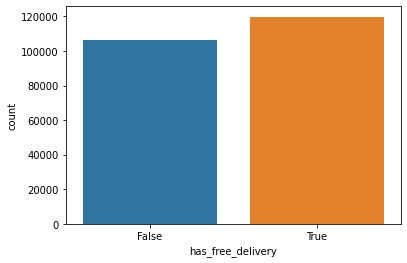

In [124]:
sns.countplot(df_orders_copia.has_free_delivery)

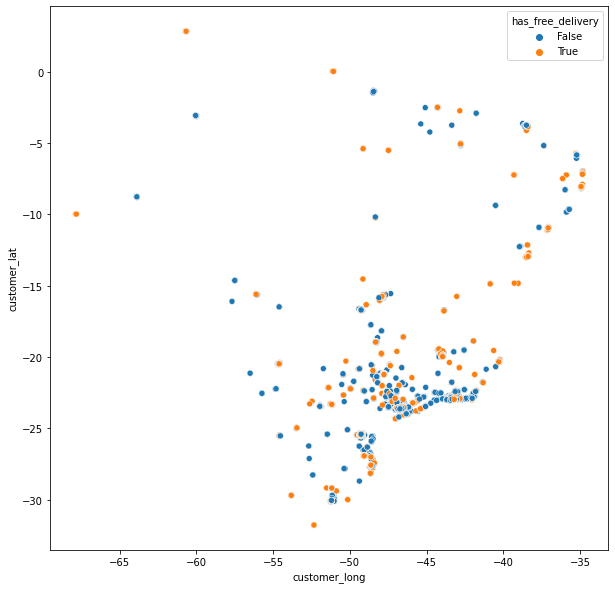

In [125]:
# plotando os dados de lat e long dos customers por free delivery
plt.figure(figsize = (10,10))
sns.scatterplot(x=df_orders_copia.customer_long,
                y=df_orders_copia.customer_lat,
                hue=df_orders_copia.has_free_delivery)

In [126]:
# verificando se taxas de delivery igual a 0
# possuem delivery não grátis
df_orders_copia[(df_orders_copia.delivery_fee == 0) & (df_orders_copia.has_free_delivery == False)]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long


In [127]:
# verificando se algum delivery grátis
# possui taxa delivery diferente de 0
df_orders_copia[(df_orders_copia.delivery_fee > 0) & (df_orders_copia.has_free_delivery == True)]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long


Acabamos de verificar que has_free_delivery não possui inconsistências com delivery_fee

In [128]:
# incluindo na versao de modelo de ordens
df_orders_model['has_free_delivery'] = df_orders_copia['has_free_delivery']

In [129]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   account_id         226268 non-null  object 
 1   order_shift        226268 non-null  object 
 2   order_origin       226268 non-null  object 
 3   delivery_fee       226268 non-null  float64
 4   scheduled          226268 non-null  object 
 5   total_amount       226268 non-null  float64
 6   subsidy_amount     226268 non-null  float64
 7   device_platform    226268 non-null  object 
 8   state_label        226268 non-null  object 
 9   city               226268 non-null  object 
 10  district           226268 non-null  object 
 11  customer_long      226268 non-null  float64
 12  customer_lat       226268 non-null  float64
 13  dish_type          226268 non-null  object 
 14  merchant_long      226268 non-null  float64
 15  merchant_lat       226268 non-null  float64
 16  me



*   **confirmed_date**: data de confirmação do pedido
*   **concluded_date**: data de conclusão do pedido



In [130]:
df_orders_copia[['confirmed_date', 'concluded_date']]

,confirmed_date,concluded_date
0,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z
1,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z
2,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z
3,2020-08-19T20:16:16.718Z,2020-08-19T22:16:16.298Z
4,2020-04-15T13:01:55.231Z,2020-04-15T17:02:37.723Z
...,...,...
226264,2020-05-31T01:12:22.097Z,2020-05-31T03:23:49.538Z
226265,2020-06-30T08:27:56.247Z,2020-06-30T08:51:08.729Z
226266,2020-04-29T20:18:36.920Z,2020-04-30T00:18:36.307Z
226267,2020-09-24T09:35:59.186Z,2020-09-24T09:59:05.377Z


In [131]:
# transformando para formato de data
df_orders_copia['confirmed_date'] = pd.to_datetime(df_orders_copia['confirmed_date'], format='%Y-%m-%d %H:%M')
df_orders_copia['concluded_date'] = pd.to_datetime(df_orders_copia['concluded_date'], format='%Y-%m-%d %H:%M')


In [132]:
# verificando as colunas
df_orders_copia[['confirmed_date', 'concluded_date']].head()

,confirmed_date,concluded_date
0,2020-02-28 14:07:25.953000+00:00,2020-02-28 16:06:03.701000+00:00
1,2020-08-21 21:12:23.295000+00:00,2020-08-21 21:59:18.732000+00:00
2,2020-07-02 20:21:51.900000+00:00,2020-07-02 20:53:39.176000+00:00
3,2020-08-19 20:16:16.718000+00:00,2020-08-19 22:16:16.298000+00:00
4,2020-04-15 13:01:55.231000+00:00,2020-04-15 17:02:37.723000+00:00


In [133]:
print('data conclusão de {} a {}'.format(df_orders_copia['concluded_date'].min(), df_orders_copia['concluded_date'].max()))

data conclusão de 2020-02-01 01:02:08.216000+00:00 a 2020-10-01 01:57:49.250000+00:00


In [134]:
# criando uma feature de tempo de espera em minutos
df_orders_copia['order_time'] = (df_orders_copia['concluded_date'] - df_orders_copia['confirmed_date']).astype('timedelta64[m]')

In [135]:
df_orders_copia['order_time'].describe()

count    226250.000000
mean        131.827421
std         190.941024
min        -239.000000
25%          35.000000
50%         119.000000
75%         239.000000
max       10828.000000
Name: order_time, dtype: float64

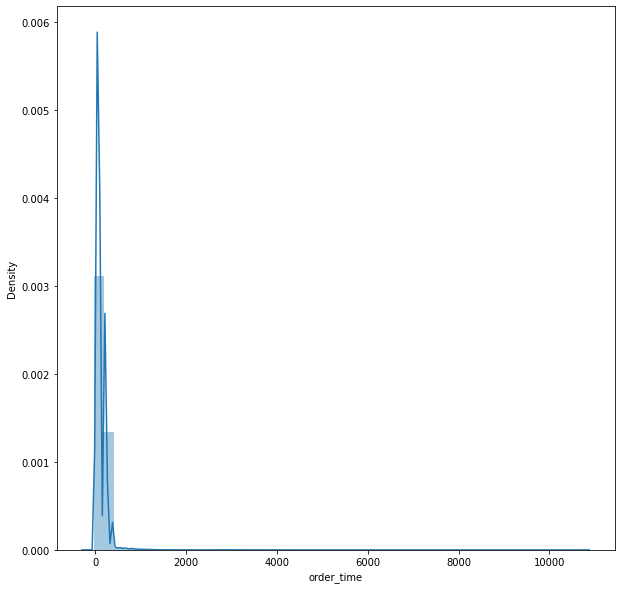

In [136]:
# plotando a distribuição do tempo de espera
plt.figure(figsize = (10,10))
sns.distplot(df_orders_copia['order_time'])

Os valores negativos, vou substituir pela mediana

In [137]:
df_orders_copia[df_orders_copia['order_time']<0]

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at,centroide_id_lat,centroide_id_long,order_time
118908,2f329f8d-cce5-478a-ba02-5a9a7bfb57e3,weekday lunch,RESTAURANT,1123.75,False,3623.75,0.00,IOS,MOBILE,9.69.0,SP,PIRACICABA,CAMPESTRE,-47.65,-22.77,3d19285ed53fba46b06587a6d3de7119b1b04e59095523...,Comida Variada,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.73-47.65,SP,PIRACICABA,CENTRO,13400370,-47.66,-22.73,False,2020-09-30 16:39:52.419000+00:00,2020-09-30 12:54:36.521000+00:00,1.0,bff84b0d-c10f-419a-b47d-6fd7266ff966,5.0,10,2020-10-02T14:48:31.093Z,-22.77,-47.65,-226.0
225167,fbc4be1f-95e9-41d9-8d56-2403b28dcaf3,weekday lunch,RESTAURANT,0.00,False,4125.00,498.75,IOS,MOBILE,9.37.1,DF,BRASILIA,GAMA,-48.07,-16.02,245076a49512f6a82ade4dd68f37c31ebea761c090a063...,Lanches,aaf2d18944b82963a137b5aef3d5a187ebfedc5917f241...,-16.01-48.06,DF,BRASILIA,GAMA,72405610,-48.07,-16.02,True,2020-09-30 16:39:34.566000+00:00,2020-09-30 12:40:57.663000+00:00,2.0,907f5863-5adc-4d7c-81d6-201a5da6f653,2.0,10,2020-09-30T15:46:02.139Z,-16.01,-48.07,-239.0


In [138]:
# substituindo os valores negativos
order_time_median = df_orders_copia[df_orders_copia['order_time']>=0]['order_time'].median()
df_orders_copia['order_time'].replace(-226, order_time_median, inplace = True)
df_orders_copia['order_time'].replace(-239, order_time_median, inplace = True)

In [139]:
# substituindo vazios pela mediana
order_time_median = df_orders_copia[df_orders_copia['order_time']>=0]['order_time'].median()
df_orders_copia['order_time'].fillna(order_time_median, inplace=True)

In [140]:
df_orders_copia['order_time'].describe()

count    226268.000000
mean        131.829507
std         190.930393
min           0.000000
25%          35.000000
50%         119.000000
75%         239.000000
max       10828.000000
Name: order_time, dtype: float64

Como uma feature de diferença dos tempos de conclusão e pedido, podemos não considerar as features originais confirmed_date e concluded_date na versao de modelo

In [141]:
# verificando o dataset
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   order_id              226268 non-null  object             
 1   order_shift           226268 non-null  object             
 2   order_origin          226268 non-null  object             
 3   delivery_fee          226268 non-null  float64            
 4   scheduled             226268 non-null  object             
 5   total_amount          226268 non-null  float64            
 6   subsidy_amount        226268 non-null  float64            
 7   device_platform       226268 non-null  object             
 8   device_type           226268 non-null  object             
 9   device_app_version    221833 non-null  object             
 10  state_label           226268 non-null  object             
 11  city                  226268 non-null  object       

In [142]:
# incluindo na versao de modelo de ordens
df_orders_model['order_time'] = df_orders_copia['order_time']

In [143]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   account_id         226268 non-null  object 
 1   order_shift        226268 non-null  object 
 2   order_origin       226268 non-null  object 
 3   delivery_fee       226268 non-null  float64
 4   scheduled          226268 non-null  object 
 5   total_amount       226268 non-null  float64
 6   subsidy_amount     226268 non-null  float64
 7   device_platform    226268 non-null  object 
 8   state_label        226268 non-null  object 
 9   city               226268 non-null  object 
 10  district           226268 non-null  object 
 11  customer_long      226268 non-null  float64
 12  customer_lat       226268 non-null  float64
 13  dish_type          226268 non-null  object 
 14  merchant_long      226268 non-null  float64
 15  merchant_lat       226268 non-null  float64
 16  me



*   **lag_last_order**: tempo, em dias, entre pedido atual e último



In [144]:
df_orders_copia.lag_last_order.describe()

count    226084.000000
mean          2.505286
std          11.985066
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max        1429.000000
Name: lag_last_order, dtype: float64

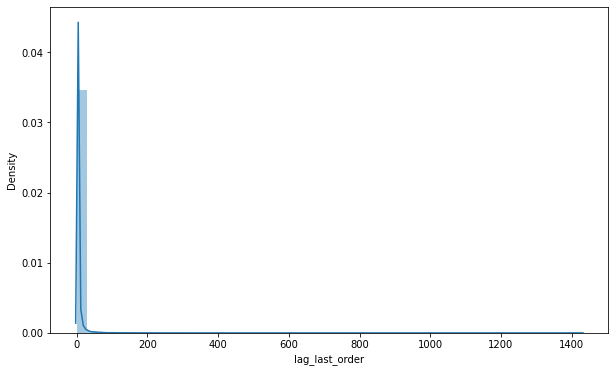

In [145]:
# distribuição dos tempos entre pedido atual e último
plt.figure(figsize = (10,6))
sns.distplot(df_orders_copia.lag_last_order)

Como visto, há dados faltantes nessa feature.

Então, vamos substituir pela mediana

In [146]:
# preenchendo vazios com mediana
df_orders_copia.lag_last_order.fillna(df_orders_copia.lag_last_order.median(), inplace = True)

In [147]:
# verificando o dataset
df_orders_copia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   order_id              226268 non-null  object             
 1   order_shift           226268 non-null  object             
 2   order_origin          226268 non-null  object             
 3   delivery_fee          226268 non-null  float64            
 4   scheduled             226268 non-null  object             
 5   total_amount          226268 non-null  float64            
 6   subsidy_amount        226268 non-null  float64            
 7   device_platform       226268 non-null  object             
 8   device_type           226268 non-null  object             
 9   device_app_version    221833 non-null  object             
 10  state_label           226268 non-null  object             
 11  city                  226268 non-null  object       

In [148]:
# incluindo na versao de modelo de ordens
df_orders_model['lag_last_order'] = df_orders_copia['lag_last_order']



*   **review_score**



In [149]:
# quantidade de avaliações
df_orders_copia.review_score.value_counts()

5.0    192537
4.0     13565
1.0      8966
3.0      7502
2.0      3698
Name: review_score, dtype: int64

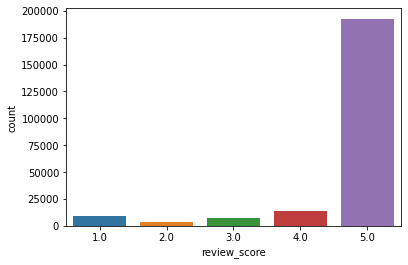

In [150]:
# distribuição gráfica
sns.countplot(df_orders_copia.review_score)

In [151]:
# incluindo na versao de modelo de ordens
df_orders_model['review_score'] = df_orders_copia['review_score']



*   **nps_score**



In [152]:
df_orders_copia.nps_score.value_counts()

10    159724
9      20381
8      18886
7       8956
1       5514
5       5065
6       3836
4       1812
3       1142
2        952
Name: nps_score, dtype: int64

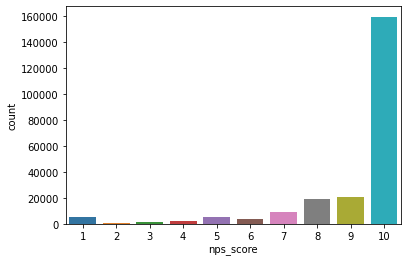

In [153]:
# distribuição gráfica
sns.countplot(df_orders_copia.nps_score)

In [154]:
# incluindo na versao de modelo de ordens
df_orders_model['nps_score'] = df_orders_copia['nps_score']



*   **review_created_date**



In [155]:
df_orders_copia.review_created_at

0         2020-02-28T19:06:31.861Z
1         2020-09-04T00:14:14.365Z
2         2020-07-03T03:49:03.214Z
3         2020-08-26T17:44:08.137Z
4         2020-04-17T22:05:13.983Z
                    ...           
226264    2020-05-31T06:24:22.437Z
226265    2020-06-30T17:13:24.936Z
226266    2020-05-04T23:33:37.180Z
226267    2020-09-24T13:53:18.336Z
226268    2020-06-21T22:21:54.666Z
Name: review_created_at, Length: 226268, dtype: object

In [156]:
# transformando para o formato de data
df_orders_copia['review_created_at'] = pd.to_datetime(df_orders_copia['review_created_at'], format='%Y-%m-%d %H:%M')

In [157]:
df_orders_copia.review_created_at.head()

0   2020-02-28 19:06:31.861000+00:00
1   2020-09-04 00:14:14.365000+00:00
2   2020-07-03 03:49:03.214000+00:00
3   2020-08-26 17:44:08.137000+00:00
4   2020-04-17 22:05:13.983000+00:00
Name: review_created_at, dtype: datetime64[ns, UTC]

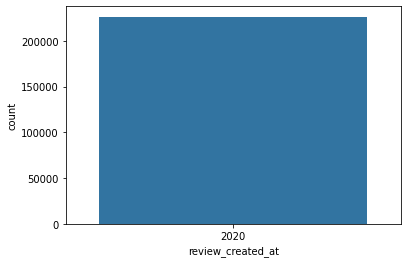

In [158]:
sns.countplot(df_orders_copia['review_created_at'].dt.year)

A data de criação do review não será considerada na versão de modelo de ordens

In [159]:
# informações gerais de ordens na versão de modelo
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   account_id         226268 non-null  object 
 1   order_shift        226268 non-null  object 
 2   order_origin       226268 non-null  object 
 3   delivery_fee       226268 non-null  float64
 4   scheduled          226268 non-null  object 
 5   total_amount       226268 non-null  float64
 6   subsidy_amount     226268 non-null  float64
 7   device_platform    226268 non-null  object 
 8   state_label        226268 non-null  object 
 9   city               226268 non-null  object 
 10  district           226268 non-null  object 
 11  customer_long      226268 non-null  float64
 12  customer_lat       226268 non-null  float64
 13  dish_type          226268 non-null  object 
 14  merchant_long      226268 non-null  float64
 15  merchant_lat       226268 non-null  float64
 16  me

### Conclusão Orders



*   valor negativo de delivery fee foi setado para 0
*   device_app_version, centroid_id, restaurant_id, group_id, merchant_zipcode e review_created_date não serão considerados na primeira análise
*   Os nomes de district e merchant_district foram padronizados para maiuscula e sem caracteres especiais
*   latitude e longitude de customer e merchant foram ajustadis (dados que não faziam sentido foram substituidos por medias de locais de mesma cidade)
*   Concluded_date e confirmed_date foram substituidos por Order_time, que é a diferença, em minutos, entre elas


## Sessions

In [160]:
# criando um df de cópia de sessions
df_sessions_copia = df_sessions.copy()

In [161]:
df_sessions_copia.describe()

,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber
count,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,2.848111e+06,3.591511e+06,3.591511e+06
mean,6.541976e+00,3.401753e+00,1.613600e+00,2.015747e+00,7.375651e-01,3.995431e+01,1.161834e+03,1.795756e+06
std,1.290502e+01,6.024095e+00,2.866229e+00,4.228897e+00,2.103870e+00,1.019375e+03,1.121173e+03,1.036780e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.597200e+04,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.240000e+02,8.978785e+05
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,8.310000e+02,1.795756e+06
75%,8.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,6.000000e+00,1.650000e+03,2.693634e+06
max,2.612000e+03,6.350000e+02,3.020000e+02,4.220000e+02,6.810000e+02,1.120474e+06,6.149000e+03,3.591511e+06


In [162]:
# informações gerais do dataset
df_sessions_copia.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 15 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   session_id                  3591511 non-null  object 
 1   user_account_uuid           3591511 non-null  object 
 2   session_started             3591511 non-null  object 
 3   session_ended               3545766 non-null  object 
 4   install_timestamp           11543 non-null    object 
 5   sum_view_restaurant_screen  3591511 non-null  int64  
 6   sum_view_dish_screen        3591511 non-null  int64  
 7   sum_click_add_item          3591511 non-null  int64  
 8   sum_view_checkout           3591511 non-null  int64  
 9   sum_callback_purchase       3591511 non-null  int64  
 10  first_order_has_voucher     420630 non-null   object 
 11  media_campaign              53423 non-null    object 
 12  load_time                   2848111 non-null  float64
 1



*   **session_id**



O id da sessão é o mesmo do id da ordem?

In [163]:
# session_id unicos
df_sessions_copia.session_id.nunique()

3591511

In [164]:
# verificando se session_id corresponde a order_id
(df_orders_copia['order_id'].isin(df_sessions_copia.session_id.to_list())).sum()

0

Session_id não corresponde a order_id.

Então, podemos não considerar session_id no nosso modelo



*   **user_account_uuid**


user_account_uuid corresponde a account_id?

In [165]:
# user_account_uuid unicos
df_sessions_copia.user_account_uuid.nunique()

20095

In [166]:
# verificando se user_account_uuid corresponde a account_id
(df_orders_copia['account_id'].isin(df_sessions_copia.user_account_uuid.to_list())).sum()

222579

Sim, user_account_uuid corresponde a account_id

Então, precisamos dessa feature no nosso df de modelo

In [167]:
# incluindo user_account_uuid no nosso df de modelo
# trocando o nome para accout_id
df_sessions_model['account_id'] = df_sessions_copia['user_account_uuid']



*   **session_started** e **session_ended**



In [168]:
df_sessions_copia[['session_started', 'session_ended']]

,session_started,session_ended
0,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z
1,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z
2,2020-02-01T00:00:14.479Z,2020-02-01T00:08:20.102Z
3,2020-02-01T00:00:14.650Z,2020-02-01T00:02:49.615Z
4,2020-02-01T00:00:41.607Z,2020-02-01T00:16:57.415Z
...,...,...
3591506,2020-09-30T23:59:29.388Z,2020-10-01T00:00:18.295Z
3591507,2020-09-30T23:59:37.159Z,2020-10-01T00:44:50.978Z
3591508,2020-09-30T23:59:40.218Z,2020-10-01T00:01:49.361Z
3591509,2020-09-30T23:59:51.837Z,2020-10-01T00:01:56.597Z


In [169]:
# transformando as features 'session_started' e 'session_ended' em datetime
df_sessions_copia['session_started'] = pd.to_datetime(df_sessions_copia['session_started'], format='%Y-%m-%d')
df_sessions_copia['session_ended'] = pd.to_datetime(df_sessions_copia['session_ended'], format='%Y-%m-%d')

In [170]:
# criando uma feature de tempo de espera em minutos
df_sessions_copia['session_time'] = (df_sessions_copia['session_ended'] - df_sessions_copia['session_started']).astype('timedelta64[m]')

In [171]:
df_sessions_copia['session_time'].describe()

count    3.545766e+06
mean     2.021223e+01
std      2.850316e+03
min     -5.356737e+06
25%      1.000000e+00
50%      8.000000e+00
75%      2.800000e+01
max      1.195450e+05
Name: session_time, dtype: float64

In [172]:
session_time_median = df_sessions_copia['session_time'].median()

df_sessions_copia.loc[(df_sessions_copia.session_time<0), 'session_time'] = session_time_median

In [173]:
df_sessions_copia.session_time.fillna(session_time_median, inplace=True)

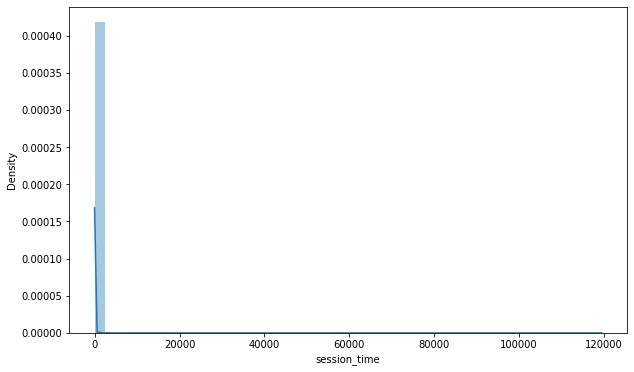

In [174]:
plt.figure(figsize = (10,6))
sns.distplot(df_sessions_copia['session_time'])

In [175]:
# incluindo session_time no nosso df de modelo
df_sessions_model['session_time'] = df_sessions_copia['session_time']

In [176]:
df_sessions_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 2 columns):
 #   Column        Dtype  
---  ------        -----  
 0   account_id    object 
 1   session_time  float64
dtypes: float64(1), object(1)
memory usage: 54.8+ MB




*   **install_timestamp**: Primeira instalação do app, após setup



Como são muitos dados vazios, não vamos considera-los no df de modelo



*   **sum_view_restaurant_screen**: Qtd de restaurantes vistos



In [177]:
df_sessions_copia.sum_view_restaurant_screen.describe()

count    3.591511e+06
mean     6.541976e+00
std      1.290502e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      8.000000e+00
max      2.612000e+03
Name: sum_view_restaurant_screen, dtype: float64

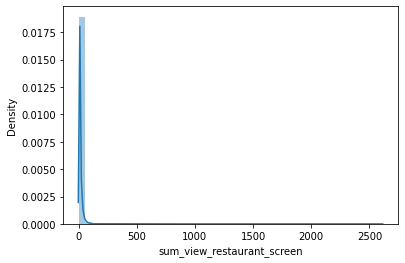

In [178]:
sns.distplot(df_sessions_copia.sum_view_restaurant_screen)

In [179]:
# incluindo sum_view_restaurant_screen no nosso df de modelo
df_sessions_model['sum_view_restaurant_screen'] = df_sessions_copia['sum_view_restaurant_screen']



*   **sum_view_dish_screen**



In [180]:
df_sessions_copia.sum_view_dish_screen.describe()

count    3.591511e+06
mean     3.401753e+00
std      6.024095e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      4.000000e+00
max      6.350000e+02
Name: sum_view_dish_screen, dtype: float64

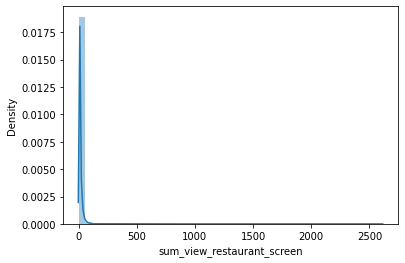

In [181]:
sns.distplot(df_sessions_copia.sum_view_restaurant_screen)

In [182]:
# incluindo sum_view_dish_screen no nosso df de modelo
df_sessions_model['sum_view_dish_screen'] = df_sessions_copia['sum_view_dish_screen']



*   **sum_click_add_item**



In [183]:
df_sessions_copia.sum_click_add_item.describe()

count    3.591511e+06
mean     1.613600e+00
std      2.866229e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.020000e+02
Name: sum_click_add_item, dtype: float64

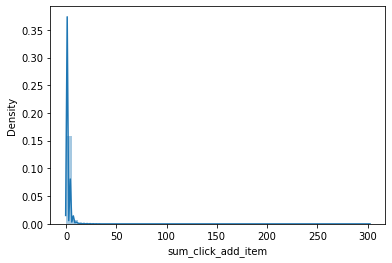

In [184]:
sns.distplot(df_sessions_copia.sum_click_add_item)

In [185]:
# incluindo sum_click_add_item no nosso df de modelo
df_sessions_model['sum_click_add_item'] = df_sessions_copia['sum_click_add_item']



*   **sum_view_checkout**



In [186]:
df_sessions_copia.sum_view_checkout.describe()

count    3.591511e+06
mean     2.015747e+00
std      4.228897e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      4.220000e+02
Name: sum_view_checkout, dtype: float64

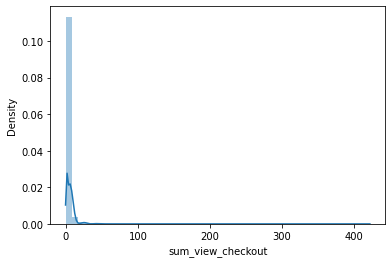

In [187]:
sns.distplot(df_sessions_copia.sum_view_checkout)

In [188]:
# incluindo sum_view_checkout no nosso df de modelo
df_sessions_model['sum_view_checkout'] = df_sessions_copia['sum_view_checkout']



*   **sum_callback_purchase**



In [189]:
df_sessions_copia.sum_callback_purchase.describe()

count    3.591511e+06
mean     7.375651e-01
std      2.103870e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.810000e+02
Name: sum_callback_purchase, dtype: float64

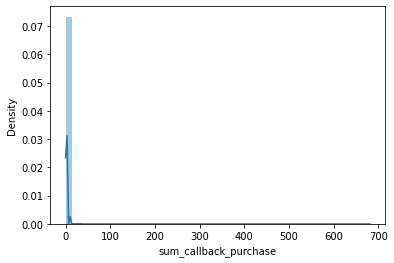

In [190]:
sns.distplot(df_sessions_copia.sum_callback_purchase)

In [191]:
# incluindo sum_callback_purchase no nosso df de modelo
df_sessions_model['sum_callback_purchase'] = df_sessions_copia['sum_callback_purchase']



*   **first_order_has_voucher**



In [192]:
df_sessions_copia.first_order_has_voucher.value_counts()

False    360336
True      60294
Name: first_order_has_voucher, dtype: int64

Há pelo menos uma resposta para cada usuário?

In [193]:
df_sessions_copia.groupby('user_account_uuid')['first_order_has_voucher'].value_counts()

user_account_uuid                     first_order_has_voucher
00008f48-df50-41cc-998b-03e3c0dc373a  False                      17
000545e9-7929-42fa-8515-d67b4d5c3fc9  False                      27
                                      True                        1
00073adf-7117-44ba-90fe-5879c9581b68  False                      11
000b1fec-8616-4014-9581-c5a944911ac3  False                      32
                                                                 ..
fffbe0eb-4420-4f1d-b360-a3c235d02ea3  True                       13
                                      False                      10
fffd0e0e-43e3-4705-8299-d5c9b016c3e4  False                      27
fffeddb7-19ce-4a16-999a-41f5fed5fc96  False                      16
                                      True                        3
Name: first_order_has_voucher, Length: 29414, dtype: int64

In [194]:
# verificando todos que tem True como resposta
id_voucher = df_sessions_copia[df_sessions_copia.first_order_has_voucher==True]['user_account_uuid'].to_list()

In [195]:
df_sessions_copia.loc[(df_sessions_copia.user_account_uuid.isin(id_voucher)), 'user_account_uuid'] = 'True'

In [196]:
df_sessions_copia['user_account_uuid'] = np.where((df_sessions_copia.user_account_uuid.isin(id_voucher)),'True',df_sessions_copia.user_account_uuid)

In [197]:
df_sessions_copia.first_order_has_voucher.value_counts()

False    360336
True      60294
Name: first_order_has_voucher, dtype: int64

In [198]:
df_sessions_copia.groupby('user_account_uuid')['first_order_has_voucher'].value_counts()

user_account_uuid                     first_order_has_voucher
00008f48-df50-41cc-998b-03e3c0dc373a  False                      17
00073adf-7117-44ba-90fe-5879c9581b68  False                      11
0019a335-0326-4032-af5b-7b76413633e0  False                      33
002492b4-a2c4-4980-9920-453fddf0428e  False                      25
002e922f-92ac-4895-bda5-2310789a70fa  False                      19
                                                                 ..
ffe014a4-7685-4de1-a18e-81388bb448f5  False                      13
ffe7588d-0345-40ad-b524-ff382a0056ff  False                      15
ffe7eaa2-72ef-4ada-b554-901796c91994  False                      19
ffed5c4e-e18a-4cfc-b985-472d18b5b1f0  False                       2
fffd0e0e-43e3-4705-8299-d5c9b016c3e4  False                      27
Name: first_order_has_voucher, Length: 9085, dtype: int64

In [199]:
# incluindo first_order_has_voucher no nosso df de modelo
df_sessions_model['first_order_has_voucher'] = df_sessions_copia['first_order_has_voucher']



*   **media_campaign**



In [200]:
df_sessions_copia['media_campaign'].value_counts()

CAMPANHA    53423
Name: media_campaign, dtype: int64

In [201]:
df_sessions_copia['media_campaign'].replace('CAMPANHA', 'True', inplace = True)

In [202]:
df_sessions_copia['media_campaign'].value_counts()

True    53423
Name: media_campaign, dtype: int64

In [203]:
df_sessions_copia.fillna('False', inplace = True)
df_sessions_copia['media_campaign'].value_counts()

False    3538088
True       53423
Name: media_campaign, dtype: int64

In [204]:
# incluindo media_campaign no nosso df de modelo
df_sessions_model['media_campaign'] = df_sessions_copia['media_campaign']



*   **load_time**



In [205]:
df_sessions_copia[df_sessions_copia.load_time != 'False']['load_time'].median()

4.0

In [206]:
# substituindo False pela mediana
df_sessions_copia.load_time.replace('False', 4, inplace=True)

In [207]:
df_sessions_copia.load_time.describe()

count    3.591511e+06
mean     3.251220e+01
std      9.078831e+02
min     -7.597200e+04
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      1.120474e+06
Name: load_time, dtype: float64

In [208]:
# valores negativos pela mediana
df_sessions_copia.loc[(df_sessions_copia.load_time<0), 'load_time'] = 4

In [209]:
df_sessions_copia.load_time.describe()

count    3.591511e+06
mean     3.256198e+01
std      9.069841e+02
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      1.120474e+06
Name: load_time, dtype: float64

In [210]:
df_sessions_copia.load_time.fillna(4, inplace=True)

In [211]:
# incluindo load_time no nosso df de modelo
df_sessions_model['load_time'] = df_sessions_copia['load_time']



*   **available_restaurants**



In [212]:
df_sessions_copia.available_restaurants.describe()

count    3.591511e+06
mean     1.161834e+03
std      1.121173e+03
min      0.000000e+00
25%      3.240000e+02
50%      8.310000e+02
75%      1.650000e+03
max      6.149000e+03
Name: available_restaurants, dtype: float64

In [213]:
# incluindo available_restaurants no nosso df de modelo
df_sessions_model['available_restaurants'] = df_sessions_copia['available_restaurants']



*   **rownumber**



In [214]:
df_sessions_copia.rownumber

0                1
1                2
2                3
3                4
4                5
            ...   
3591506    3591507
3591507    3591508
3591508    3591509
3591509    3591510
3591510    3591511
Name: rownumber, Length: 3591511, dtype: int64

Rownumber não será considerado na df de modelo

In [215]:
df_sessions_model.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   account_id                  3591511 non-null  object 
 1   session_time                3591511 non-null  float64
 2   sum_view_restaurant_screen  3591511 non-null  int64  
 3   sum_view_dish_screen        3591511 non-null  int64  
 4   sum_click_add_item          3591511 non-null  int64  
 5   sum_view_checkout           3591511 non-null  int64  
 6   sum_callback_purchase       3591511 non-null  int64  
 7   first_order_has_voucher     420630 non-null   object 
 8   media_campaign              3591511 non-null  object 
 9   load_time                   3591511 non-null  float64
 10  available_restaurants       3591511 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 301.4+ MB


### Conclusão Sessions



*   Algumas features foram desconsideradas, como session_id
*   horario de fechamento e abertura foram substituidas pela diferença entre elas
*   primeira copra com voucher será True para cada um que tiver True em pelo menos uma compra



# Pré Processamento

Para processar esses três dataset, vamos juntar em apenas um.

Para isso, vamos fazer o seguinte:

 - verificar quem fez compra pelo dataset de orders
 - seleciona-los na df de marketing
 - unir com dados deles de sessions
 - para isso, usar moda para categoricas e media para numericas


## Agrupando quem comprou em Orders

In [216]:
df_orders_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226268 entries, 0 to 226268
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   account_id         226268 non-null  object 
 1   order_shift        226268 non-null  object 
 2   order_origin       226268 non-null  object 
 3   delivery_fee       226268 non-null  float64
 4   scheduled          226268 non-null  object 
 5   total_amount       226268 non-null  float64
 6   subsidy_amount     226268 non-null  float64
 7   device_platform    226268 non-null  object 
 8   state_label        226268 non-null  object 
 9   city               226268 non-null  object 
 10  district           226268 non-null  object 
 11  customer_long      226268 non-null  float64
 12  customer_lat       226268 non-null  float64
 13  dish_type          226268 non-null  object 
 14  merchant_long      226268 non-null  float64
 15  merchant_lat       226268 non-null  float64
 16  me

In [217]:
# separando features numericas e categoricas
orders_numericas = df_orders_model.select_dtypes(exclude=["object"]).columns.to_list()
orders_categoricas = df_orders_model.select_dtypes(include=["object"]).columns.to_list()
orders_categoricas.remove('account_id')

In [290]:
# agrupando por account_id
df_orders_model_num = df_orders_model.groupby('account_id')[orders_numericas].mean()
df_orders_model_cat = df_orders_model.groupby('account_id')[orders_categoricas].agg(pd.Series.mode)

In [291]:
df_orders_model_cat

,order_shift,order_origin,scheduled,device_platform,state_label,city,district,dish_type,merchant_state,merchant_city,merchant_district,has_free_delivery
account_id,,,,,,,,,,,,
00073adf-7117-44ba-90fe-5879c9581b68,weekday lunch,RESTAURANT,False,ANDROID,PR,CURITIBA,PORTAO,Marmita,PR,CURITIBA,AGUA VERDE,True
000b1fec-8616-4014-9581-c5a944911ac3,weekday dinner,RESTAURANT,False,ANDROID,RJ,RIO DE JANEIRO,CENTRO,"[Comida Brasileira, Lanches, Pizza, Tapioca]",RJ,RIO DE JANEIRO,LAPA,"[False, True]"
000db136-b110-4dd6-9d1c-a70ab1ab2d75,weekday dinner,RESTAURANT,False,ANDROID,SP,SAO PAULO,VILA DOS REMEDIOS,Lanches,SP,SAO PAULO,VILA LEOPOLDINA,True
000f5a0c-cfac-44f9-a296-7f745b38a863,"[weekday lunch, weekend lunch]",RESTAURANT,False,IOS,SP,SAO PAULO,VILA ERNESTO,Mercado,SP,SAO PAULO,VILA PREL,False
0019a335-0326-4032-af5b-7b76413633e0,"[weekday dinner, weekday lunch]",RESTAURANT,False,ANDROID,SP,SAO PAULO,VILA POMPEIA,"[Comida Contemporânea, Comida Japonesa]",SP,SAO PAULO,"[CERQUEIRA CESAR, HIGIENOPOLIS]",False
...,...,...,...,...,...,...,...,...,...,...,...,...
ffed5c4e-e18a-4cfc-b985-472d18b5b1f0,weekend lunch,RESTAURANT,False,IOS,SP,SAO PAULO,CERQUEIRA CESAR,Comida Brasileira,SP,SAO PAULO,JARDINS,False
ffef562a-c954-4405-b89a-95908342766e,weekday dinner,RESTAURANT,False,ANDROID,RJ,RIO DE JANEIRO,BENTO RIBEIRO,Comida Brasileira,RJ,RIO DE JANEIRO,CASCADURA,False
fffbe0eb-4420-4f1d-b360-a3c235d02ea3,weekend dinner,RESTAURANT,False,IOS,SP,SAO PAULO,VILA DA SAUDE,"[Comida Japonesa, Hambúrguer]",SP,SAO PAULO,VILA MARIANA,True


## Agrupando em Sessions (numericas)

In [295]:
df_sessions_model.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 11 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   account_id                  3591511 non-null  object 
 1   session_time                3591511 non-null  float64
 2   sum_view_restaurant_screen  3591511 non-null  int64  
 3   sum_view_dish_screen        3591511 non-null  int64  
 4   sum_click_add_item          3591511 non-null  int64  
 5   sum_view_checkout           3591511 non-null  int64  
 6   sum_callback_purchase       3591511 non-null  int64  
 7   first_order_has_voucher     420630 non-null   object 
 8   media_campaign              3591511 non-null  object 
 9   load_time                   3591511 non-null  float64
 10  available_restaurants       3591511 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 301.4+ MB


In [294]:
# separando features numericas e categoricas
sessions_numericas = df_sessions_model.select_dtypes(exclude=["object"]).columns.to_list()
sessions_categoricas = df_sessions_model.select_dtypes(include=["object"]).columns.to_list()
sessions_categoricas.remove('account_id')

In [296]:
# agrupando por account_id
df_sessions_model_num = df_sessions_model.groupby('account_id')[sessions_numericas].mean()

In [297]:
df_sessions_model_num.head()

,session_time,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants
account_id,,,,,,,,
00008f48-df50-41cc-998b-03e3c0dc373a,15.613139,7.445255,2.248175,1.496350,1.335766,0.686131,3.642336,556.620438
000545e9-7929-42fa-8515-d67b4d5c3fc9,14.226087,4.095652,1.269565,0.913043,0.800000,0.591304,4.200000,2502.347826
00073adf-7117-44ba-90fe-5879c9581b68,21.065657,3.520202,2.282828,1.308081,2.439394,0.792929,19.611111,803.696970
000b1fec-8616-4014-9581-c5a944911ac3,26.974359,3.666667,2.484330,1.509972,2.837607,1.205128,23.079772,978.327635
000c857f-0bc8-4d4b-8533-b56c44425488,23.744186,2.720930,3.209302,1.441860,2.767442,0.581395,6.534884,557.976744


## Agrupando todos com Marketing

In [299]:
df_marketing_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   account_id         20249 non-null  object        
 1   registration_date  20249 non-null  datetime64[ns]
 2   first_order_date   20249 non-null  datetime64[ns]
 3   ifood_status       20249 non-null  object        
 4   total_order_count  20249 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 791.1+ KB


In [303]:
df_marketing_model.set_index('account_id', inplace=True)

In [304]:
df_marketing_model.head()

,registration_date,first_order_date,ifood_status,total_order_count
account_id,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,2020-02-28,Inactive,8
16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,2017-03-19,Churn,457
61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,2018-09-02,Active,206
82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,2018-05-01,Reactivated,47
382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,2019-08-12,Inactive,66


In [305]:
df_marketing_model['registration_time']=(df_marketing_model['first_order_date'] - df_marketing_model['registration_date']).astype('timedelta64[m]')

In [307]:
df_marketing_model.drop(['first_order_date','registration_date'], axis=1, inplace=True)

In [308]:
df_marketing_model.head()

,ifood_status,total_order_count,registration_time
account_id,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,Inactive,8,37440.0
16d0afba-00b8-427a-ba1f-2e397a9fbb54,Churn,457,440640.0
61c051ee-d37c-45c6-8c22-c236db3b62b7,Active,206,0.0
82e48692-e4fa-494e-b03e-6815a819b7b1,Reactivated,47,247680.0
382af025-14c8-4ba9-b62f-deddd6f25789,Inactive,66,10080.0


In [312]:
df_total = df_orders_model.join(df_sessions_model)

ValueError: ignored

In [311]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20249 entries, 7c0450e7-a806-4208-8449-e4269a27e6b5 to ed2a5774-8181-4d38-94ac-1dd55f3f5da3
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ifood_status       20249 non-null  object 
 1   total_order_count  20249 non-null  int64  
 2   registration_time  20249 non-null  float64
 3   account_id         0 non-null      object 
 4   order_shift        0 non-null      object 
 5   order_origin       0 non-null      object 
 6   delivery_fee       0 non-null      float64
 7   scheduled          0 non-null      object 
 8   total_amount       0 non-null      float64
 9   subsidy_amount     0 non-null      float64
 10  device_platform    0 non-null      object 
 11  state_label        0 non-null      object 
 12  city               0 non-null      object 
 13  district           0 non-null      object 
 14  customer_long      0 non-null      float64
 15  customer_

Como não consegui fazer um join, vou rodar a clusterização somente para orders

# Modelo Cluster

In [315]:
scaler = RobustScaler() 
numeric_cols = list(df_orders_model.dtypes[df_orders_model.dtypes !='object'].index)
df_orders_model.loc[:,numeric_cols] = scaler.fit_transform(df_orders_model.loc[:,numeric_cols])

In [325]:
numeric_cols

['delivery_fee',
 'total_amount',
 'subsidy_amount',
 'customer_long',
 'customer_lat',
 'merchant_long',
 'merchant_lat',
 'order_time',
 'lag_last_order',
 'review_score',
 'nps_score']

In [323]:
categ_cols = list(df_orders_model.dtypes[df_orders_model.dtypes =='object'].index)[1:]

In [324]:
categ_cols

['order_shift',
 'order_origin',
 'scheduled',
 'device_platform',
 'state_label',
 'city',
 'district',
 'dish_type',
 'merchant_state',
 'merchant_city',
 'merchant_district',
 'has_free_delivery']

In [327]:
df_orders_model = df_orders_model[['order_shift',
 'order_origin',
 'scheduled',
 'device_platform',
 'state_label',
 'city',
 'district',
 'dish_type',
 'merchant_state',
 'merchant_city',
 'merchant_district',
 'has_free_delivery',
 'delivery_fee',
 'total_amount',
 'subsidy_amount',
 'customer_long',
 'customer_lat',
 'merchant_long',
 'merchant_lat',
 'order_time',
 'lag_last_order',
 'review_score',
 'nps_score']]

In [328]:
df_orders_model.head()

,order_shift,order_origin,scheduled,device_platform,state_label,city,district,dish_type,merchant_state,merchant_city,merchant_district,has_free_delivery,delivery_fee,total_amount,subsidy_amount,customer_long,customer_lat,merchant_long,merchant_lat,order_time,lag_last_order,review_score,nps_score
0,weekday lunch,RESTAURANT,False,ANDROID,RJ,RIO DE JANEIRO,COELHO NETO,Comida Brasileira,RJ,RIO DE JANEIRO,PAVUNA,False,1.168614,0.184017,0.000000,0.973214,1.060606,0.967164,1.092308,-0.004902,0.0,0.0,-2.0
1,weekend dinner,RESTAURANT,False,IOS,RJ,RIO DE JANEIRO,FLAMENGO,Comida Brasileira,RJ,RIO DE JANEIRO,RIO COMPRIDO,True,0.000000,-0.318086,2.004008,1.023810,0.893939,1.014925,0.938462,-0.357843,0.0,0.0,-2.0
2,weekday dinner,RESTAURANT,False,IOS,SP,SAO PAULO,VILA CLEMENTINO,Comida Peruana,SP,SAO PAULO,INDIANOPOLIS,True,0.000000,-0.160358,3.404810,-0.008929,-0.106061,-0.014925,-0.123077,-0.431373,1.0,0.0,-5.0
3,weekday dinner,RESTAURANT,False,DESKTOP,RJ,RIO DE JANEIRO,CURICICA,Pizza,RJ,RIO DE JANEIRO,CURICICA,False,1.151920,-0.475815,0.002004,0.961310,0.863636,0.961194,0.892308,0.000000,-0.5,0.0,0.0
4,weekday lunch,RESTAURANT,False,DESKTOP,SP,SAO PAULO,LIBERDADE,Comida Brasileira,SP,SAO PAULO,VILA MARIANA,True,0.000000,-0.368034,0.000000,-0.005952,-0.060606,-0.005970,-0.076923,0.593137,0.0,0.0,0.0


In [332]:
pip install kmodes

In [333]:
from kmodes.kprototypes import KPrototypes

In [ ]:
K = range(1,15)

cost = []

for num_clusters in K:
    kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
    kproto.fit_predict(df_orders_model, categorical=[0,1,2,3,4,5,6,7,8,9,10,11])
    cost.append(kproto.cost_)

plt.plot(cost)

In [ ]:
kproto = KPrototypes(n_clusters = 6, init='Cao')
kproto.fit_predict(df_orders_model, categorical=[0,1,2,3,4,5,6,7,8,9,10,11])

In [ ]:
original['cluster_proto'] = kproto.labels_
original.head()

In [ ]:
original.groupby(['cluster_proto']).mean()